# Image preprocessing for easier classes distinguishment

In [6]:
# imports
import numpy as np
import tensorflow as tf
import keras
import os

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers

import pandas as pd
import matplotlib.pyplot as plt
import cv2

TensorFlow version: 2.10.0
Keras version: 2.10.0


## Image directories

In [2]:
# The path to store trained models
models_dir = r'./models/' 
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where is original dataset
original_dataset_dir = r'./data/preprocessed_images/'

# The directory where we will store our smaller dataset
base_dir = r'./dataset256/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

split_dir = base_dir + r'split256/'
if not os.path.exists(split_dir):
    os.mkdir(split_dir)

# Prepare directories for the class separation
normal_dir = os.path.join(split_dir, r'normal256')
if not os.path.exists(normal_dir):
    os.mkdir(normal_dir)
    
diabetes_dir = os.path.join(split_dir, r'diabetes256')
if not os.path.exists(diabetes_dir):
    os.mkdir(diabetes_dir)
    
glaucoma_dir = os.path.join(split_dir, r'glaucoma256')
if not os.path.exists(glaucoma_dir):
    os.mkdir(glaucoma_dir)
    
cataract_dir = os.path.join(split_dir, r'cataract256')
if not os.path.exists(cataract_dir):
    os.mkdir(cataract_dir)
    
age_macular_dir = os.path.join(split_dir, r'age_macular256')
if not os.path.exists(age_macular_dir):
    os.mkdir(age_macular_dir)
    
hypertension_dir = os.path.join(split_dir, r'hypertension256')
if not os.path.exists(hypertension_dir):
    os.mkdir(hypertension_dir)
    
myopia_dir = os.path.join(split_dir, r'myopia256')
if not os.path.exists(myopia_dir):
    os.mkdir(myopia_dir)

other_dir = os.path.join(split_dir, r'other256')
if not os.path.exists(other_dir):
    os.mkdir(other_dir)

## Load images' data

In [3]:
# load dataset csv
df_eye = pd.read_csv('./data/df_eye.csv')
df_eye.head()

Unnamed: 0  ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0           0   0           69      Female  0_left.jpg  0_right.jpg   
1           1   1           57        Male  1_left.jpg  1_right.jpg   
2           2   2           42        Male  2_left.jpg  2_right.jpg   
3           3   4           53        Male  4_left.jpg  4_right.jpg   
4           4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

### Create data class for each disease

In [4]:
class DataClass():
    def __init__(self, _name: str, _filenames: [str], _target: [int], _abbreviation: str, _directory: str):
        self.name = _name
        self.filenames = _filenames
        self.target = _target
        self.abbreviation  = _abbreviation
        self.directory = _directory
        
    def __str__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"
    
    def __repr__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"

# THAT'S WRONG! THIS LABEL IS ATTACHED TO EACH PATIENT NOT TO EACH EYE! nvm it's correct 
normal_filenames = df_eye[df_eye.labels == "['N']"].filename.values
diabetes_filenames = df_eye[df_eye.labels == "['D']"].filename.values
glaucoma_filenames = df_eye[df_eye.labels == "['G']"].filename.values
cataract_filenames = df_eye[df_eye.labels == "['C']"].filename.values
age_macular_filenames = df_eye[df_eye.labels == "['A']"].filename.values
hypertension_filenames = df_eye[df_eye.labels == "['H']"].filename.values
myopia_filenames = df_eye[df_eye.labels == "['M']"].filename.values
other_filenames = df_eye[df_eye.labels == "['O']"].filename.values

normal_class = DataClass('normal', normal_filenames, [1, 0, 0, 0, 0, 0, 0, 0], 'N', normal_dir)
diabetes_class = DataClass('diabetes', diabetes_filenames, [0, 1, 0, 0, 0, 0, 0, 0], 'D', diabetes_dir)
glaucoma_class = DataClass('glaucoma', glaucoma_filenames, [0, 0, 1, 0, 0, 0, 0, 0], 'G', glaucoma_dir)
cataract_class = DataClass('cataract', cataract_filenames, [0, 0, 0, 1, 0, 0, 0, 0], 'C', cataract_dir)
age_macular_class = DataClass('age_macular', age_macular_filenames, [0, 0, 0, 0, 1, 0, 0, 0], 'A', age_macular_dir)
hypertension_class = DataClass('hypertension', hypertension_filenames, [0, 0, 0, 0, 0, 1, 0, 0], 'H', hypertension_dir)
myopia_class = DataClass('myopia', myopia_filenames, [0, 0, 0, 0, 0, 0, 1, 0], 'M', myopia_dir)
other_class = DataClass('other', other_filenames, [0, 0, 0, 0, 0, 0, 0, 1], 'O', other_dir)

data_classes = [
    normal_class, 
    diabetes_class, 
    glaucoma_class, 
    cataract_class, 
    age_macular_class, 
    hypertension_class, 
    myopia_class, 
    other_class
]

### Load sample images

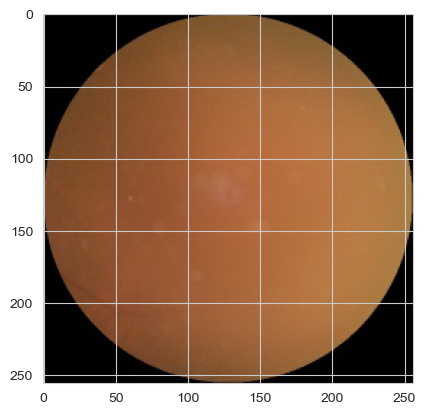

In [7]:
img_path = cataract_class.directory + "/" +  cataract_class.filenames[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [8]:
# load one img of each type to
def get_class_img(eye_disease_class):
    img_path = eye_disease_class.directory + "/" +  eye_disease_class.filenames[0]
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [9]:
img_normal = get_class_img(normal_class)
img_cataract = get_class_img(cataract_class)
img_myopia = get_class_img(myopia_class)

./dataset256/split256/normal256/0_right.jpg
./dataset256/split256/cataract256/24_right.jpg
./dataset256/split256/myopia256/13_right.jpg


In [10]:
def show_images(img_list, titles):
    assert(len(img_list) == len(titles))

    im_count = len(img_list)
    fig, axs = plt.subplots(im_count, figsize=(15,15))

    for i in range(im_count):
        axs[i].imshow(img_list[i])
        axs[i].set_title(titles[i])

img_list = [img_normal, img_cataract, img_myopia]
titles = ['normal', 'cataract', 'myopia']

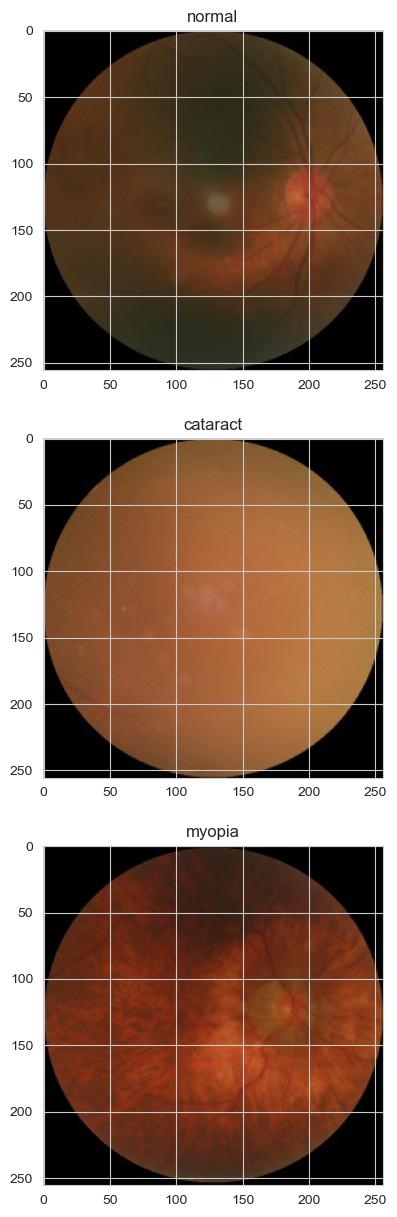

In [11]:
show_images(img_list,titles)

#### All images are in the similar coloristic and each of them has different brightness, so for simplicity I've decided to convert them to grayscale to further analysis and processing.

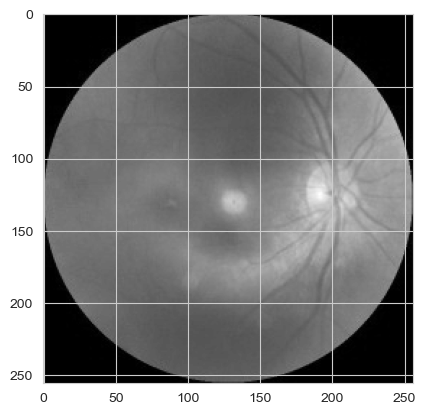

In [13]:
# convert images to grayscale
normal_gray = cv2.cvtColor(img_normal, cv2.COLOR_RGB2GRAY)
cataract_gray = cv2.cvtColor(img_cataract, cv2.COLOR_RGB2GRAY)
myopia_gray = cv2.cvtColor(img_myopia, cv2.COLOR_RGB2GRAY)

gray_img_list = [normal_gray, cataract_gray, myopia_gray]
plt.imshow(normal_gray, cmap='gray')

# Histogram analysis

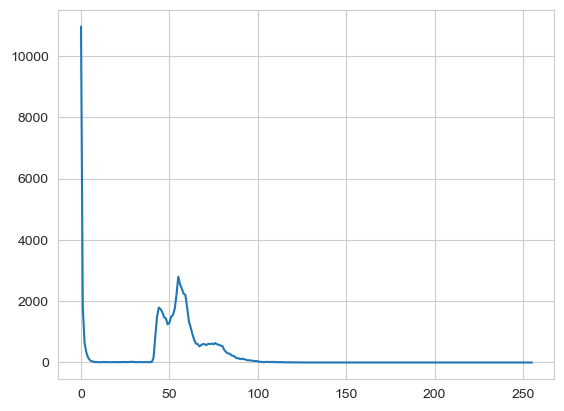

In [58]:
normal_hist = cv2.calcHist([normal_gray], [0], None, [256], [0,256])
plt.plot(normal_hist)

In [14]:
normal_hist = cv2.calcHist([normal_gray], [0], None, [256], [0,256])
cataract_hist = cv2.calcHist([cataract_gray], [0], None, [256], [0,256])
myopia_hist = cv2.calcHist([myopia_gray], [0], None, [256], [0,256])

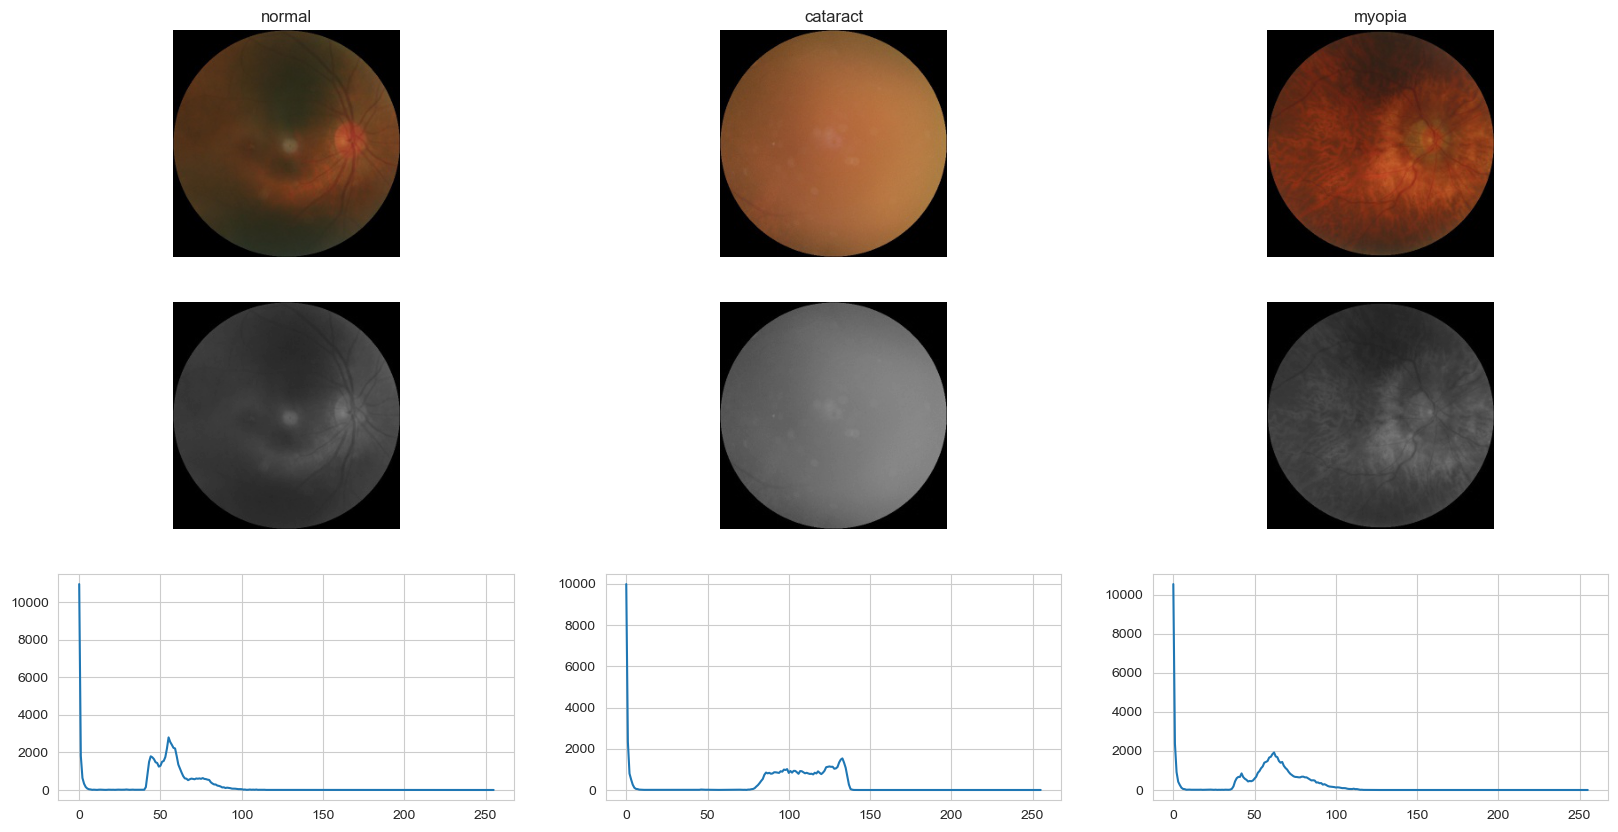

In [64]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(20, 10)

# original images
axs[0, 0].imshow(img_normal, 'gray', vmin=0, vmax=256)
axs[0, 0].set_title('normal')
axs[0, 0].axis('off')
axs[0, 1].imshow(img_cataract, 'gray', vmin=0, vmax=256)
axs[0, 1].set_title('cataract')
axs[0, 1].axis('off')
axs[0, 2].imshow(img_myopia, 'gray', vmin=0, vmax=256)
axs[0, 2].set_title('myopia')
axs[0, 2].axis('off')

# in grayscale
axs[1, 0].imshow(normal_gray, 'gray', vmin=0, vmax=256)
axs[1, 0].axis('off')
axs[1, 1].imshow(cataract_gray, 'gray', vmin=0, vmax=256)
axs[1, 1].axis('off')
axs[1, 2].imshow(myopia_gray, 'gray', vmin=0, vmax=256)
axs[1, 2].axis('off')

# plot histograms
axs[2, 0].plot(normal_hist)
axs[2, 1].plot(cataract_hist)
axs[2, 2].plot(myopia_hist)

plt.show()

## Histogram equalization (HE)

Text(0.5, 1.0, 'myopia')

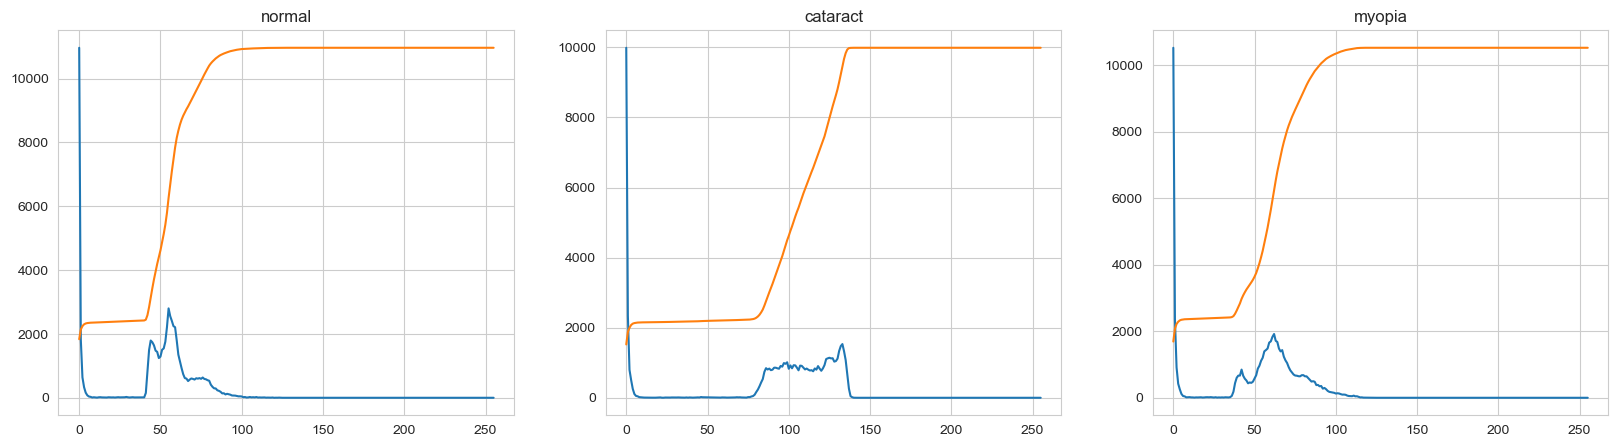

In [79]:
def plot_hist_w_cumsum(img, axis):
    his = cv2.calcHist([img], [0], None, [256], [0,256])
    cumsum = his.cumsum()
    # scale cumsum to the hist values range
    hist_cum = (cumsum / cumsum.max()) * his.max()
    axis.plot(his)
    axis.plot(hist_cum)

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

plot_hist_w_cumsum(normal_gray, axs[0])
axs[0].set_title('normal')
plot_hist_w_cumsum(cataract_gray, axs[1])
axs[1].set_title('cataract')
plot_hist_w_cumsum(myopia_gray, axs[2])
axs[2].set_title('myopia')

In [68]:
def get_normalized_cum_hist(img):
    hist = cv2.calcHist([img], [0], None, [256], (0, 256))
    hist_cum = hist.cumsum()
    hist_cum_norm = (hist_cum / hist_cum.max()) * 255
    return hist_cum_norm

In [69]:
# global hist equalization
def equalize_hist(img):
    hist_cum_norm =  get_normalized_cum_hist(img)
    equalized = cv2.LUT(img, hist_cum_norm).astype('uint8')
    return equalized


# contrast limited adaptive histogram equalization
def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit = 12, tileGridSize=(8,8))
    clahe_img = clahe.apply(img)
    return clahe_img

In [80]:
eq_normal = equalize_hist(normal_gray)
clahe_normal = CLAHE(normal_gray)

eq_cataract = equalize_hist(cataract_gray)
clahe_cataract = CLAHE(cataract_gray)

eq_myopia = equalize_hist(myopia_gray)
clahe_myopia = CLAHE(myopia_gray)

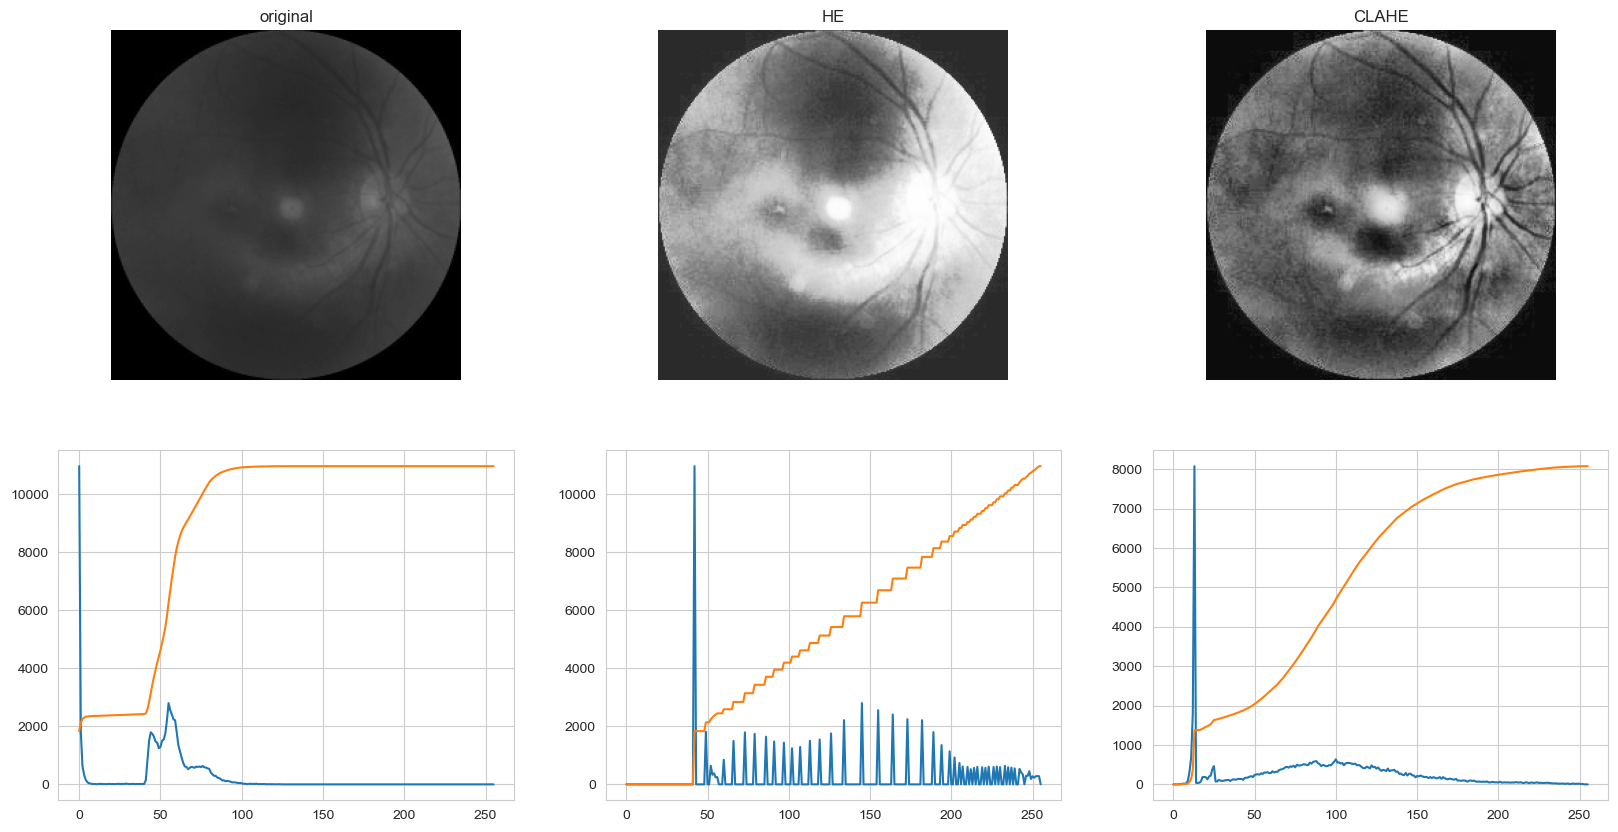

In [81]:
# show diff
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 10)

# in grayscale
axs[0, 0].imshow(normal_gray, 'gray', vmin=0, vmax=256)
axs[0, 0].axis('off')
axs[0, 0].set_title('original')
axs[0, 1].imshow(eq_normal, 'gray', vmin=0, vmax=256)
axs[0, 1].axis('off')
axs[0, 1].set_title('HE')
axs[0, 2].imshow(clahe_normal, 'gray', vmin=0, vmax=256)
axs[0, 2].axis('off')
axs[0, 2].set_title('CLAHE')

# plot histograms
# original
plot_hist_w_cumsum(normal_gray, axs[1,0])
# he
plot_hist_w_cumsum(eq_normal, axs[1,1])
# clahe
plot_hist_w_cumsum(clahe_normal, axs[1,2])

plt.show()

#### Difference is easily noticeable between original images and those after histogram equalization. Details are much better visible which might help Neural network recognize classes better. CLAHE seems to work better in this case.

In [82]:
def plot_diff(img_orig, img_gray, img_eq, img_clahe):
    fig, axs = plt.subplots(1,4)
    fig.set_size_inches(20, 5)

    axs[0].imshow(img_orig, cmap="gray", vmin=0, vmax=255)
    axs[1].imshow(img_gray, cmap="gray", vmin=0, vmax=255)
    axs[2].imshow(img_eq, cmap="gray", vmin=0, vmax=255)
    axs[3].imshow(img_clahe, cmap="gray", vmin=0, vmax=255)

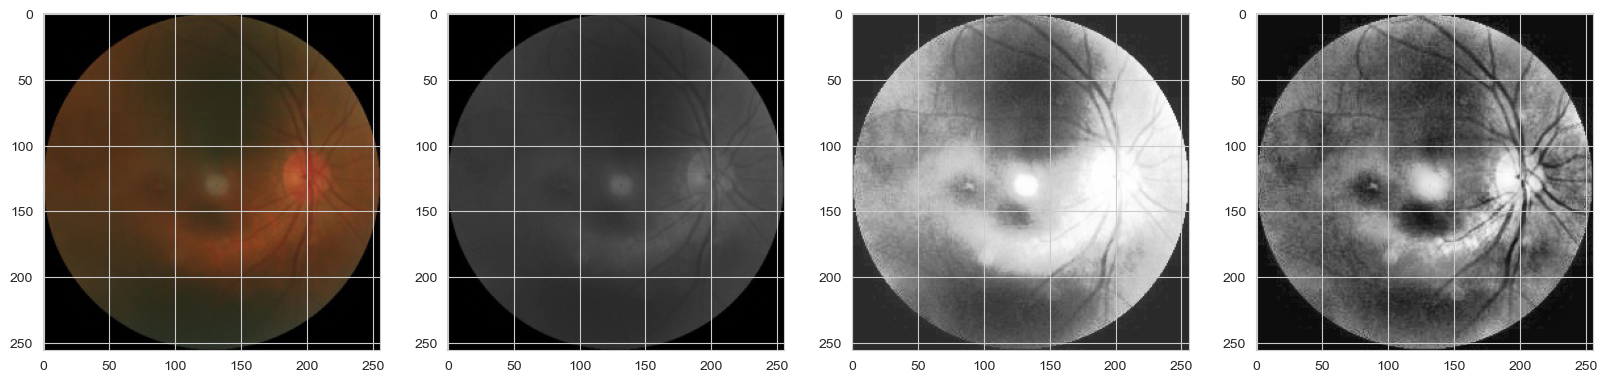

In [83]:
plot_diff(img_normal, normal_gray, eq_normal, clahe_normal)

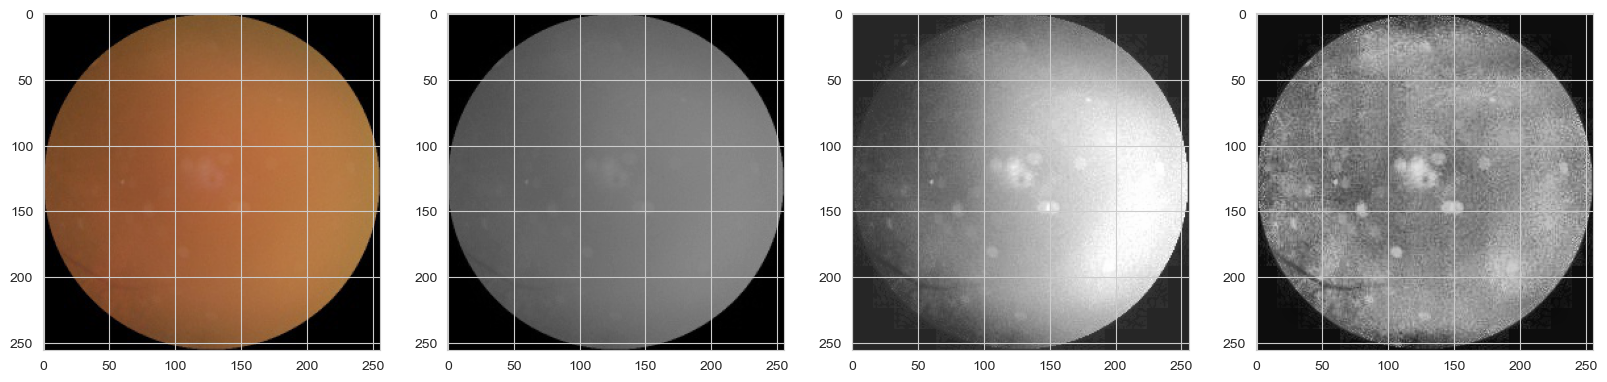

In [84]:
plot_diff(img_cataract, cataract_gray, eq_cataract, clahe_cataract)

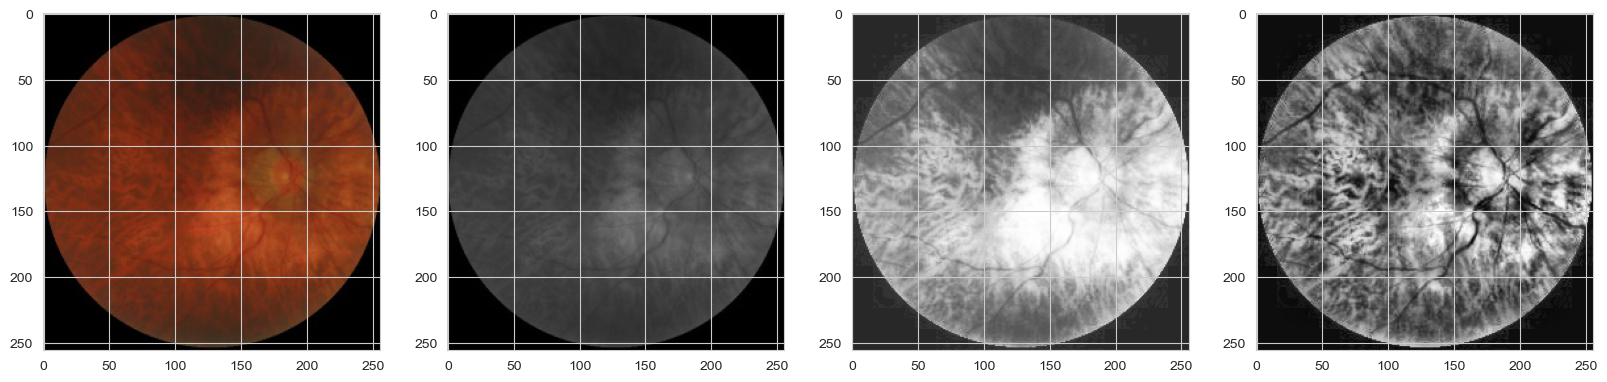

In [85]:
plot_diff(img_myopia, myopia_gray, eq_myopia, clahe_myopia)

CLAHE seems to work the best for histogram equalization in this case. Histogram equalization improved contrast and revealed more details hard to spot with naked eye. Those operations might help neural network recognize classes better and in consequence improve their performance.

In [93]:
def process_image(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe_image = CLAHE(image_gray)
    return clahe_image

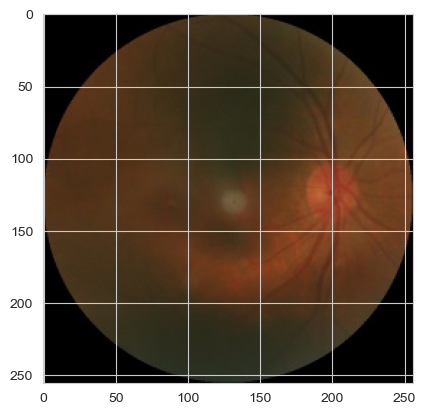

In [89]:
plt.imshow(img_normal)

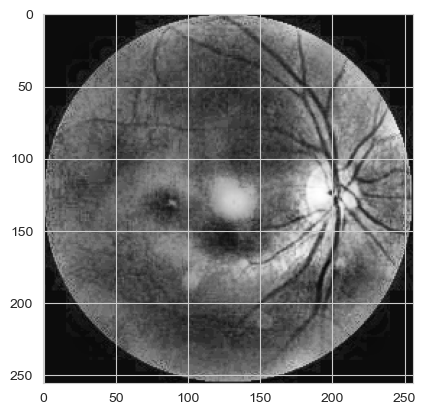

In [94]:
processed = process_image(img_normal)
plt.imshow(processed, cmap='gray')

### Apply CLAHE on all images

In [87]:
os.listdir('.')
target_dir = 'dataset256_gray'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

['.idea',
 '.ipynb_checkpoints',
 '01_eye_dis_detect.ipynb',
 '02_fix_classes.ipynb',
 '03_data_preprocessing.ipynb',
 '04_create_model.ipynb',
 '05_binary_classification-Copy1.ipynb',
 '05_binary_classification-Copy2.ipynb',
 '05_binary_classification.ipynb',
 '06_data_augmentation.ipynb',
 '07_multiclass.ipynb',
 '08_ensemble.ipynb',
 '09_imge_dim_split.ipynb',
 '10_image_processing.ipynb',
 'articles',
 'data',
 'dataset',
 'dataset250',
 'dataset256',
 'dataset256_binary',
 'dataset256_binary_augmented',
 'dataset256_binary_augmented_v2',
 'dataset256_multi',
 'dataset256_multi_equal_test',
 'dataset256_multi_equal_test - Copy',
 'models',
 'tmp']

In [5]:
# The path to store trained models
models_dir = r'./models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where is original dataset
original_dataset_dir = r'./data/preprocessed_images/'

# The directory where we will store our smaller dataset
base_dir = r'./dataset256_gray/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

split_dir = base_dir + r'split256/'
if not os.path.exists(split_dir):
    os.mkdir(split_dir)

# Prepare directories for the class separation
normal_dir = os.path.join(split_dir, r'normal256')
if not os.path.exists(normal_dir):
    os.mkdir(normal_dir)

diabetes_dir = os.path.join(split_dir, r'diabetes256')
if not os.path.exists(diabetes_dir):
    os.mkdir(diabetes_dir)

glaucoma_dir = os.path.join(split_dir, r'glaucoma256')
if not os.path.exists(glaucoma_dir):
    os.mkdir(glaucoma_dir)

cataract_dir = os.path.join(split_dir, r'cataract256')
if not os.path.exists(cataract_dir):
    os.mkdir(cataract_dir)

age_macular_dir = os.path.join(split_dir, r'age_macular256')
if not os.path.exists(age_macular_dir):
    os.mkdir(age_macular_dir)

hypertension_dir = os.path.join(split_dir, r'hypertension256')
if not os.path.exists(hypertension_dir):
    os.mkdir(hypertension_dir)

myopia_dir = os.path.join(split_dir, r'myopia256')
if not os.path.exists(myopia_dir):
    os.mkdir(myopia_dir)

other_dir = os.path.join(split_dir, r'other256')
if not os.path.exists(other_dir):
    os.mkdir(other_dir)

## Update data classes

In [6]:
class DataClass():
    def __init__(self, _name: str, _filenames: [str], _target: [int], _abbreviation: str, _directory: str):
        self.name = _name
        self.filenames = _filenames
        self.target = _target
        self.abbreviation  = _abbreviation
        self.directory = _directory

    def __str__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"

    def __repr__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"

# THAT'S WRONG! THIS LABEL IS ATTACHED TO EACH PATIENT NOT TO EACH EYE! nvm it's correct
normal_filenames = df_eye[df_eye.labels == "['N']"].filename.values
diabetes_filenames = df_eye[df_eye.labels == "['D']"].filename.values
glaucoma_filenames = df_eye[df_eye.labels == "['G']"].filename.values
cataract_filenames = df_eye[df_eye.labels == "['C']"].filename.values
age_macular_filenames = df_eye[df_eye.labels == "['A']"].filename.values
hypertension_filenames = df_eye[df_eye.labels == "['H']"].filename.values
myopia_filenames = df_eye[df_eye.labels == "['M']"].filename.values
other_filenames = df_eye[df_eye.labels == "['O']"].filename.values

normal_class = DataClass('normal', normal_filenames, [1, 0, 0, 0, 0, 0, 0, 0], 'N', normal_dir)
diabetes_class = DataClass('diabetes', diabetes_filenames, [0, 1, 0, 0, 0, 0, 0, 0], 'D', diabetes_dir)
glaucoma_class = DataClass('glaucoma', glaucoma_filenames, [0, 0, 1, 0, 0, 0, 0, 0], 'G', glaucoma_dir)
cataract_class = DataClass('cataract', cataract_filenames, [0, 0, 0, 1, 0, 0, 0, 0], 'C', cataract_dir)
age_macular_class = DataClass('age_macular', age_macular_filenames, [0, 0, 0, 0, 1, 0, 0, 0], 'A', age_macular_dir)
hypertension_class = DataClass('hypertension', hypertension_filenames, [0, 0, 0, 0, 0, 1, 0, 0], 'H', hypertension_dir)
myopia_class = DataClass('myopia', myopia_filenames, [0, 0, 0, 0, 0, 0, 1, 0], 'M', myopia_dir)
other_class = DataClass('other', other_filenames, [0, 0, 0, 0, 0, 0, 0, 1], 'O', other_dir)

data_classes = [
    normal_class,
    diabetes_class,
    glaucoma_class,
    cataract_class,
    age_macular_class,
    hypertension_class,
    myopia_class,
    other_class
]

In [104]:
# Copy files to each class dir
for data_class in data_classes:
    class_dir = data_class.directory
    if os.path.exists(class_dir) and not os.path.isfile(class_dir):
        print(class_dir)
        # Check if the directory is empty
        if not os.listdir(class_dir):
            # copy files
            for fname in data_class.filenames:
                src = os.path.join(original_dataset_dir, fname)
                img = cv2.imread(src)
                # resize img to 256x256
                resized_img = cv2.resize(img, (256, 256))
                # process image
                processed_img = process_image(resized_img)
                # save scaled img
                dst = data_class.directory + "/" + fname
                cv2.imwrite(dst, processed_img)
                # shutil.copyfile(src, dst)
    # validate if number of each class in dataframe and destination directory is the same
    assert(len(df_eye[df_eye.labels == "['" + data_class.abbreviation +  "']"]) == len(os.listdir(class_dir)))

./dataset256_gray/split256/normal256
./dataset256_gray/split256/diabetes256
./dataset256_gray/split256/glaucoma256
./dataset256_gray/split256/cataract256
./dataset256_gray/split256/age_macular256
./dataset256_gray/split256/hypertension256
./dataset256_gray/split256/myopia256
./dataset256_gray/split256/other256


## Split data

In [12]:
from random import sample

num_of_imgs = np.min([len(cataract_class.filenames), len(myopia_class.filenames), len(normal_class.filenames)])

# Copy files to each class dir
for data_class in data_classes:
    class_dir = data_class.directory
    if os.path.exists(class_dir) and not os.path.isfile(class_dir):
        # Check if the directory is empty
        if not os.listdir(class_dir):
            # copy files
            data_class.filenames = sample([*data_class.filenames],num_of_imgs)
            for fname in data_class.filenames:
                src = os.path.join(original_dataset_dir, fname)
                img = cv2.imread(src)
                # resize img to 256x256
                resized_img = cv2.resize(img, (256, 256))
                # save scaled img
                dst = data_class.directory + "/" + fname
                cv2.imwrite(dst, resized_img)
                # shutil.copyfile(src, dst)
    # validate if number of each class in dataframe and destination directory is the same
    # assert(num_of_imgs == len(os.listdir(class_dir)), "wrong")

# Split data

In [15]:
img_rows = 256
img_cols = 256

## Split data into train, validation and test sets

In [106]:
# split data another approach
!pip install split-folders

In [20]:
import splitfolders

In [107]:
splitfolders.ratio(split_dir, output="/dataset256_gray/output", seed=1337, ratio=(.7, 0.2,0.1))

Copying files: 6163 files [00:49, 123.37 files/s]


In [123]:
# classes: normal, cataract, myopia
# SETS
# set0 -> without further oversampling
# set1 -> oversampling data in order to fix imbalance between classes

# set 0
set0_split_dir = './dataset256_gray/set0'
set0_output = "./dataset256_gray/set0/output"
splitfolders.ratio(set0_split_dir, output=set0_output, seed=1337, ratio=(.7, 0.2,0.1))

Copying files: 3247 files [00:25, 127.30 files/s]


In [9]:
# set 1, oversampling in train  turned on
set1_split_dir = './dataset256_gray/set1'
set1_output = "./dataset256_gray/set1/output"
# 30 validation img, 15 test images per class
splitfolders.fixed(set1_split_dir, output=set1_output, seed=1337, fixed=(30, 15), oversample=True)

## Augmentation

In [114]:
# TODO: maybe later

## Create image generators

In [16]:
train_dir_set0 = r'./dataset256_gray/set0/output/train/'
validation_dir_set0 = r'./dataset256_gray/set0/output/val/'
test_dir_set0 = r'./dataset256_gray/set0/output/test/'

train_dir_set1 = r'./dataset256_gray/set1/output/train/'
validation_dir_set1 = r'./dataset256_gray/set1/output/val/'
test_dir_set1 = r'./dataset256_gray/set1/output/test/'

In [17]:
# with augmentation
from keras.preprocessing.image import ImageDataGenerator


def create_generators(train_dir, test_dir, validation_dir, batch_size=15, class_mode="categorical", img_rows=256, img_cols=256):
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=30,
        # shear_range=0.2,
        # zoom_range=0.05
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.1,
        # brightness_range=(0.9, 1.1)
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        # The size of batches of images
        batch_size=batch_size,
        shuffle=True,
        class_mode=class_mode,
        color_mode="grayscale")

    test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        # The size of batches of images
        batch_size=batch_size,
        class_mode=class_mode,
        color_mode="grayscale",
        # WARNING! SHUFFLE must be set to `False`, without it confusion matrix gets wrong labels
        # and it can lead to hours spent on debugging
        shuffle=False)

    validation_generator = validation_datagen.flow_from_directory(
        # This is the target directory
        validation_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        # The size of batches of images
        batch_size=batch_size,
        class_mode=class_mode,
        color_mode="grayscale",
        # WARNING! SHUFFLE must be set to `False`, without it confusion matrix gets wrong labels
        # and it can lead to hours spent on debugging
        shuffle=False)

    return train_generator, validation_generator, test_generator

In [18]:
print("SET 0 - without oversampling")
#  without oversampling
train_gen_set0, val_gen_set0, test_gen_set0 = create_generators(train_dir_set0, test_dir_set0, validation_dir_set0, batch_size=15, class_mode="categorical", img_rows=256, img_cols=256)

print("SET 1 - with oversampling")
#  with oversampling
train_gen_set1, val_gen_set1, test_gen_set1 = create_generators(train_dir_set1, test_dir_set1, validation_dir_set1, batch_size=15, class_mode="categorical", img_rows=256, img_cols=256)

SET 0 - without oversampling
Found 2272 images belonging to 3 classes.
Found 327 images belonging to 3 classes.
Found 648 images belonging to 3 classes.
SET 1 - with oversampling
Found 2865 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


## Create model

In [19]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    return model

In [20]:
model1 = build_model()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [21]:
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

#### Generators:
* without oversampling
    - train_gen_set0
    - val_gen_set0
    - test_gen_set0


* with oversampling
    - train_gen_set1
    - val_gen_set1
    - test_gen_set1

In [22]:
history1 = model1.fit(
      train_gen_set0,
      steps_per_epoch=50,
      epochs=20,
      validation_data=val_gen_set0,
      validation_steps=15)

Epoch 1/20
50/50 [==============================] - 17s 104ms/step - loss: 0.6199 - precision: 0.8315 - recall: 0.7893 - accuracy: 0.8187 - val_loss: 1.0240 - val_precision: 0.5644 - val_recall: 0.5644 - val_accuracy: 0.5644
Epoch 2/20
50/50 [==============================] - 4s 83ms/step - loss: 0.4348 - precision: 0.8678 - recall: 0.8667 - accuracy: 0.8680 - val_loss: 1.4409 - val_precision: 0.5644 - val_recall: 0.5644 - val_accuracy: 0.5644
Epoch 3/20
50/50 [==============================] - 5s 92ms/step - loss: 0.4097 - precision: 0.8719 - recall: 0.8440 - accuracy: 0.8533 - val_loss: 1.1836 - val_precision: 0.7169 - val_recall: 0.6978 - val_accuracy: 0.7156
Epoch 4/20
50/50 [==============================] - 5s 106ms/step - loss: 0.3135 - precision: 0.8934 - recall: 0.8827 - accuracy: 0.8893 - val_loss: 0.6154 - val_precision: 0.8203 - val_recall: 0.7911 - val_accuracy: 0.8000
Epoch 5/20
50/50 [==============================] - 5s 95ms/step - loss: 0.3209 - precision: 0.8913 - rec

In [23]:
test_score = model1.evaluate(test_gen_set0)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ", test_score[0])

22/22 [==============================] - 1s 47ms/step - loss: 0.2324 - precision: 0.9325 - recall: 0.9297 - accuracy: 0.9327
[INFO] accuracy: 93.25%
[INFO] Loss:  0.23235687613487244


## Validate results on confusion matrix

In [27]:
# Plot the confusion matrix based on this article: https://medium.com/analytics-vidhya/how-to-create-a-confusion-matrix-with-the-test-result-in-your-training-model-802b1315d8ee
# with couple changes to properly assign labels etc. (shuffle is turned on by default in data generators...I'll never forget)
from sklearn.metrics import classification_report, confusion_matrix
import itertools

plt.rcParams.update({'font.size': 30})


def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
def create_conf_mat(train_gen, test_gen, model):
    target_names = []
    for key in train_gen.class_indices:
        target_names.append(key)

    #Confution Matrix
    Y_pred = model.predict(test_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(test_gen.classes, y_pred, normalize='true')
    plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

    #Print Classification Report
    print('Classification Report')
    print(classification_report(test_gen.classes, y_pred, target_names=target_names))

22/22 [==============================] - 1s 31ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

 cataract256       0.83      0.68      0.75        28
   myopia256       0.88      0.65      0.75        23
   normal256       0.94      0.98      0.96       276

    accuracy                           0.93       327
   macro avg       0.88      0.77      0.82       327
weighted avg       0.93      0.93      0.93       327



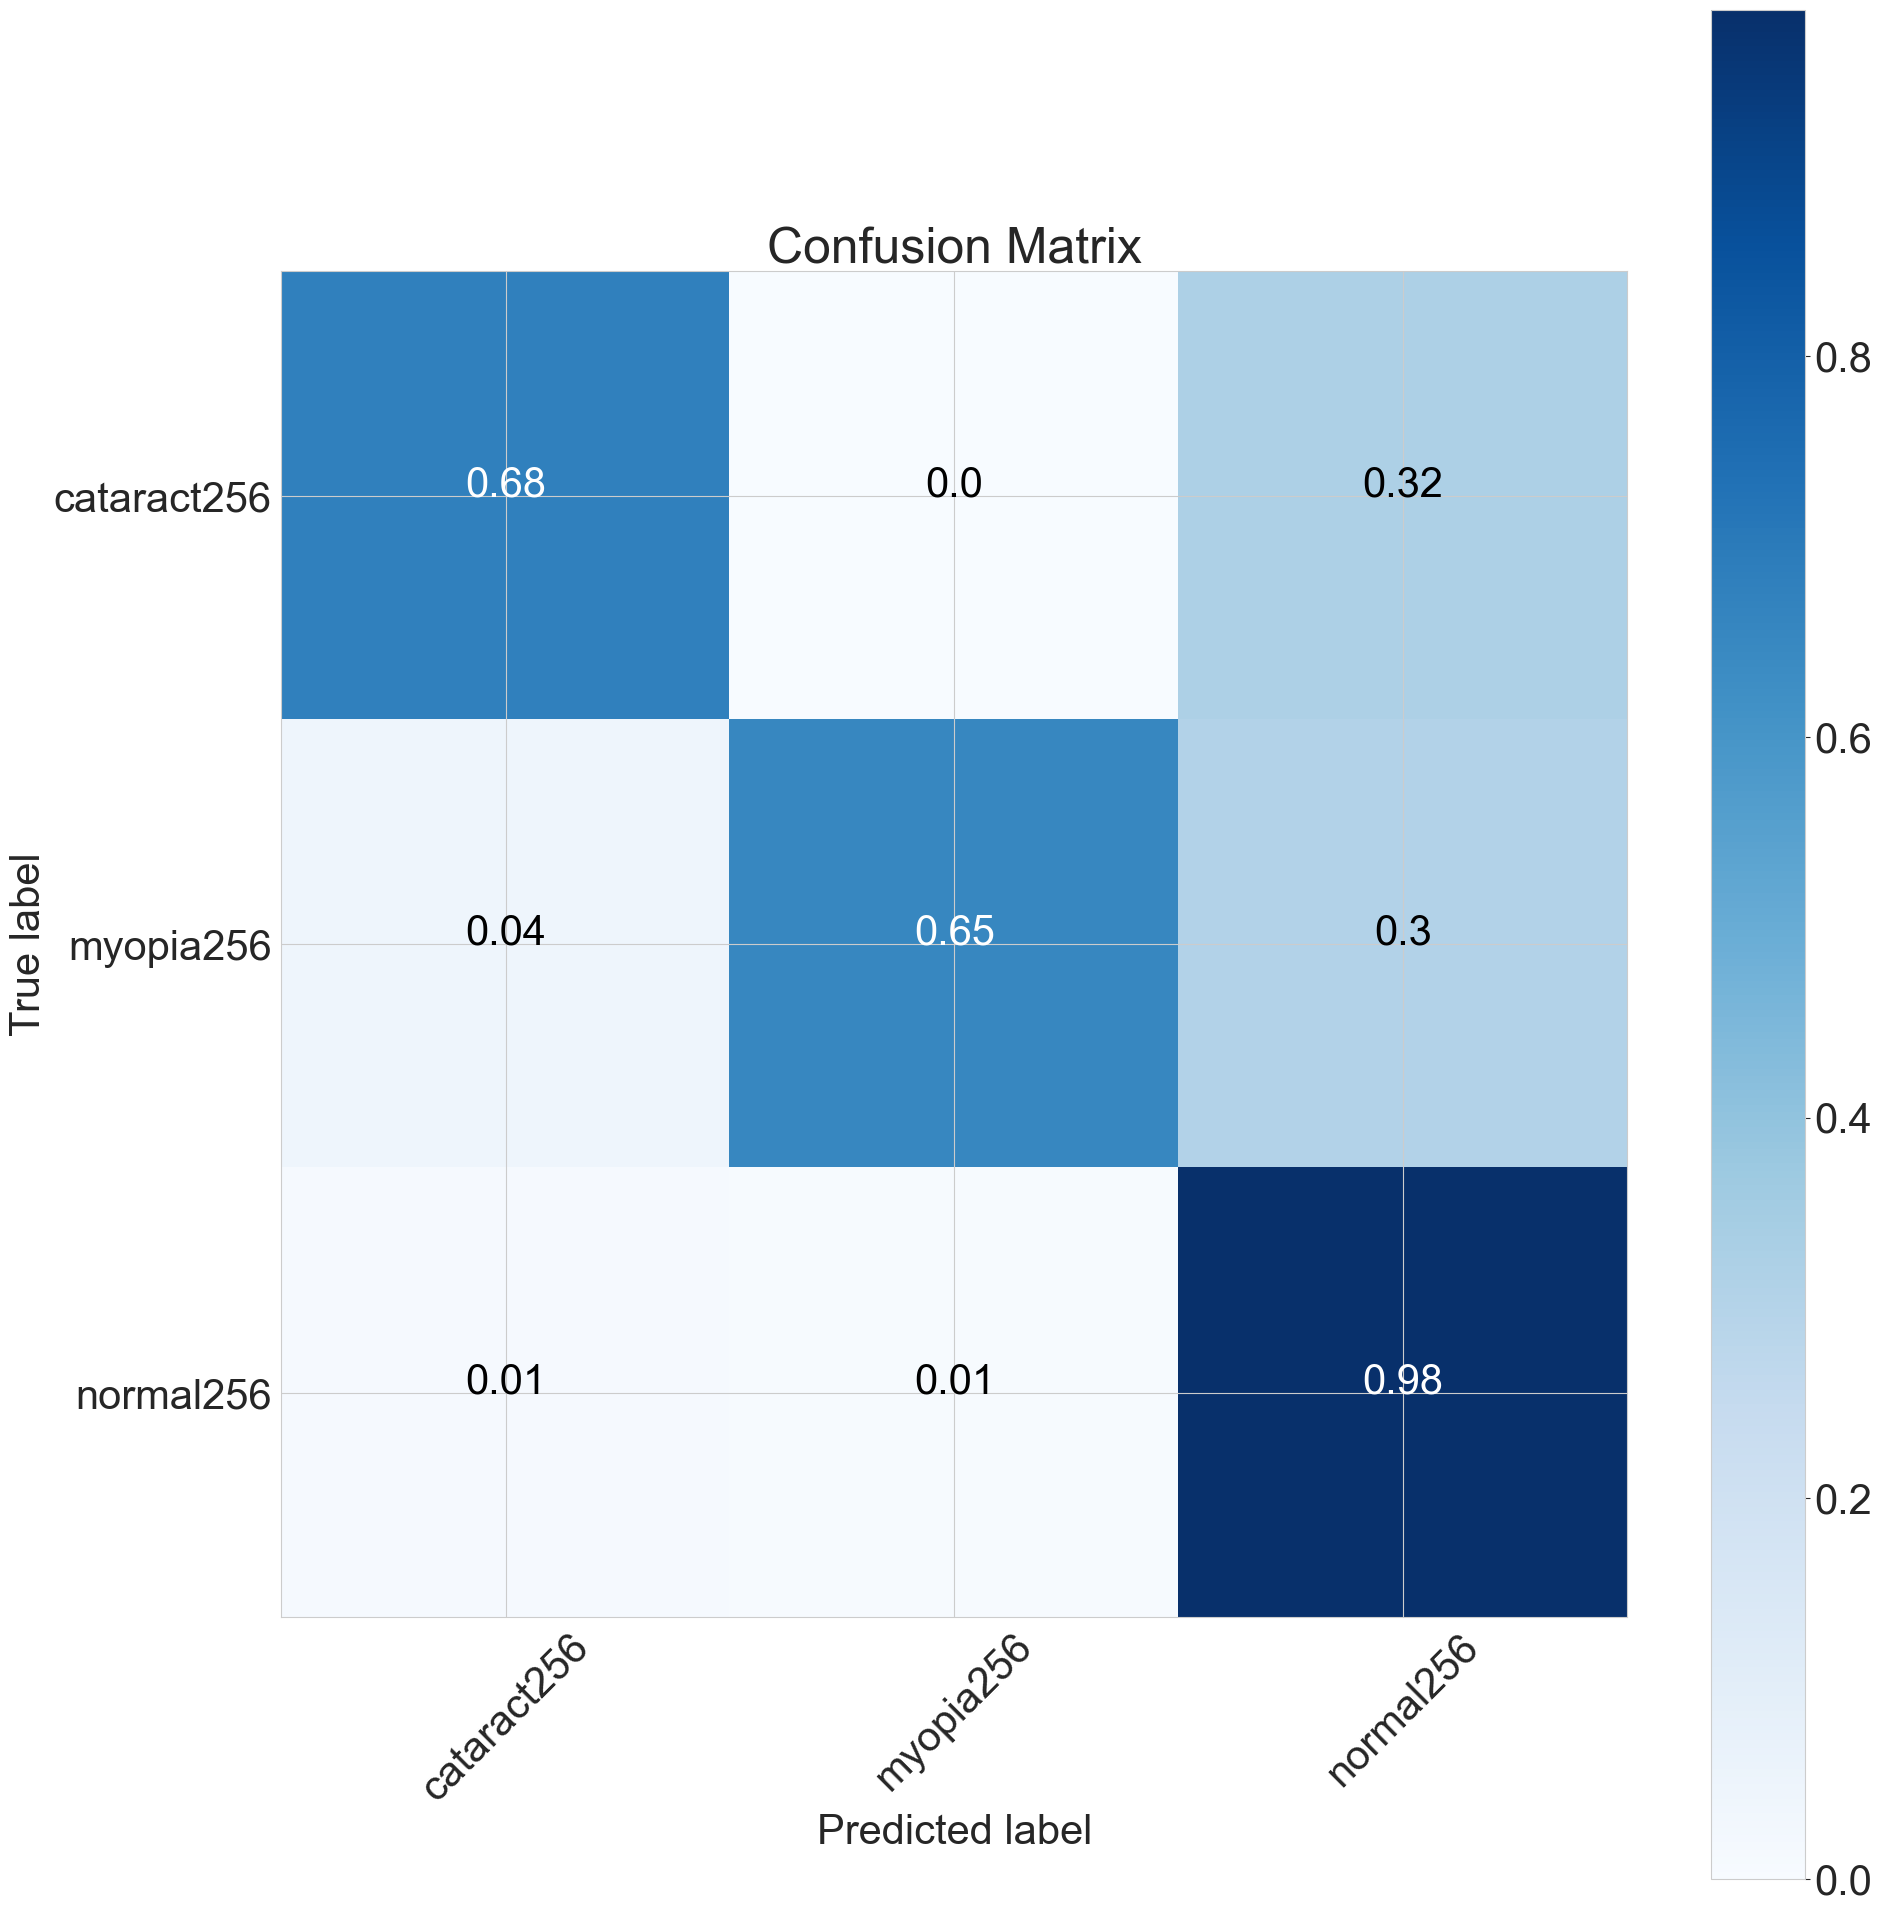

In [29]:
create_conf_mat(train_gen=train_gen_set0, test_gen=test_gen_set0, model=model1)

### Train on oversampled dataset (imbalance in train set is no more)

In [30]:
model2 = build_model()
model2.summary()

model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

history2 = model2.fit(
    train_gen_set1,
    steps_per_epoch=50,
    epochs=20,
    validation_data=val_gen_set1,
    validation_steps=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

#### Evaluate model

In [31]:
test_score = model2.evaluate(test_gen_set1)
print("[INFO] accuracy: {:.2f}%".format(test_score[3] * 100))
print("[INFO] Loss: ",test_score[0])

3/3 [==============================] - 0s 74ms/step - loss: 0.3992 - precision_1: 0.9091 - recall_1: 0.8889 - accuracy: 0.8889
[INFO] accuracy: 88.89%
[INFO] Loss:  0.39922985434532166


### Validate results on confusion matrix

3/3 [==============================] - 0s 94ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

 cataract256       0.87      0.87      0.87        15
   myopia256       0.93      0.93      0.93        15
   normal256       0.87      0.87      0.87        15

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45



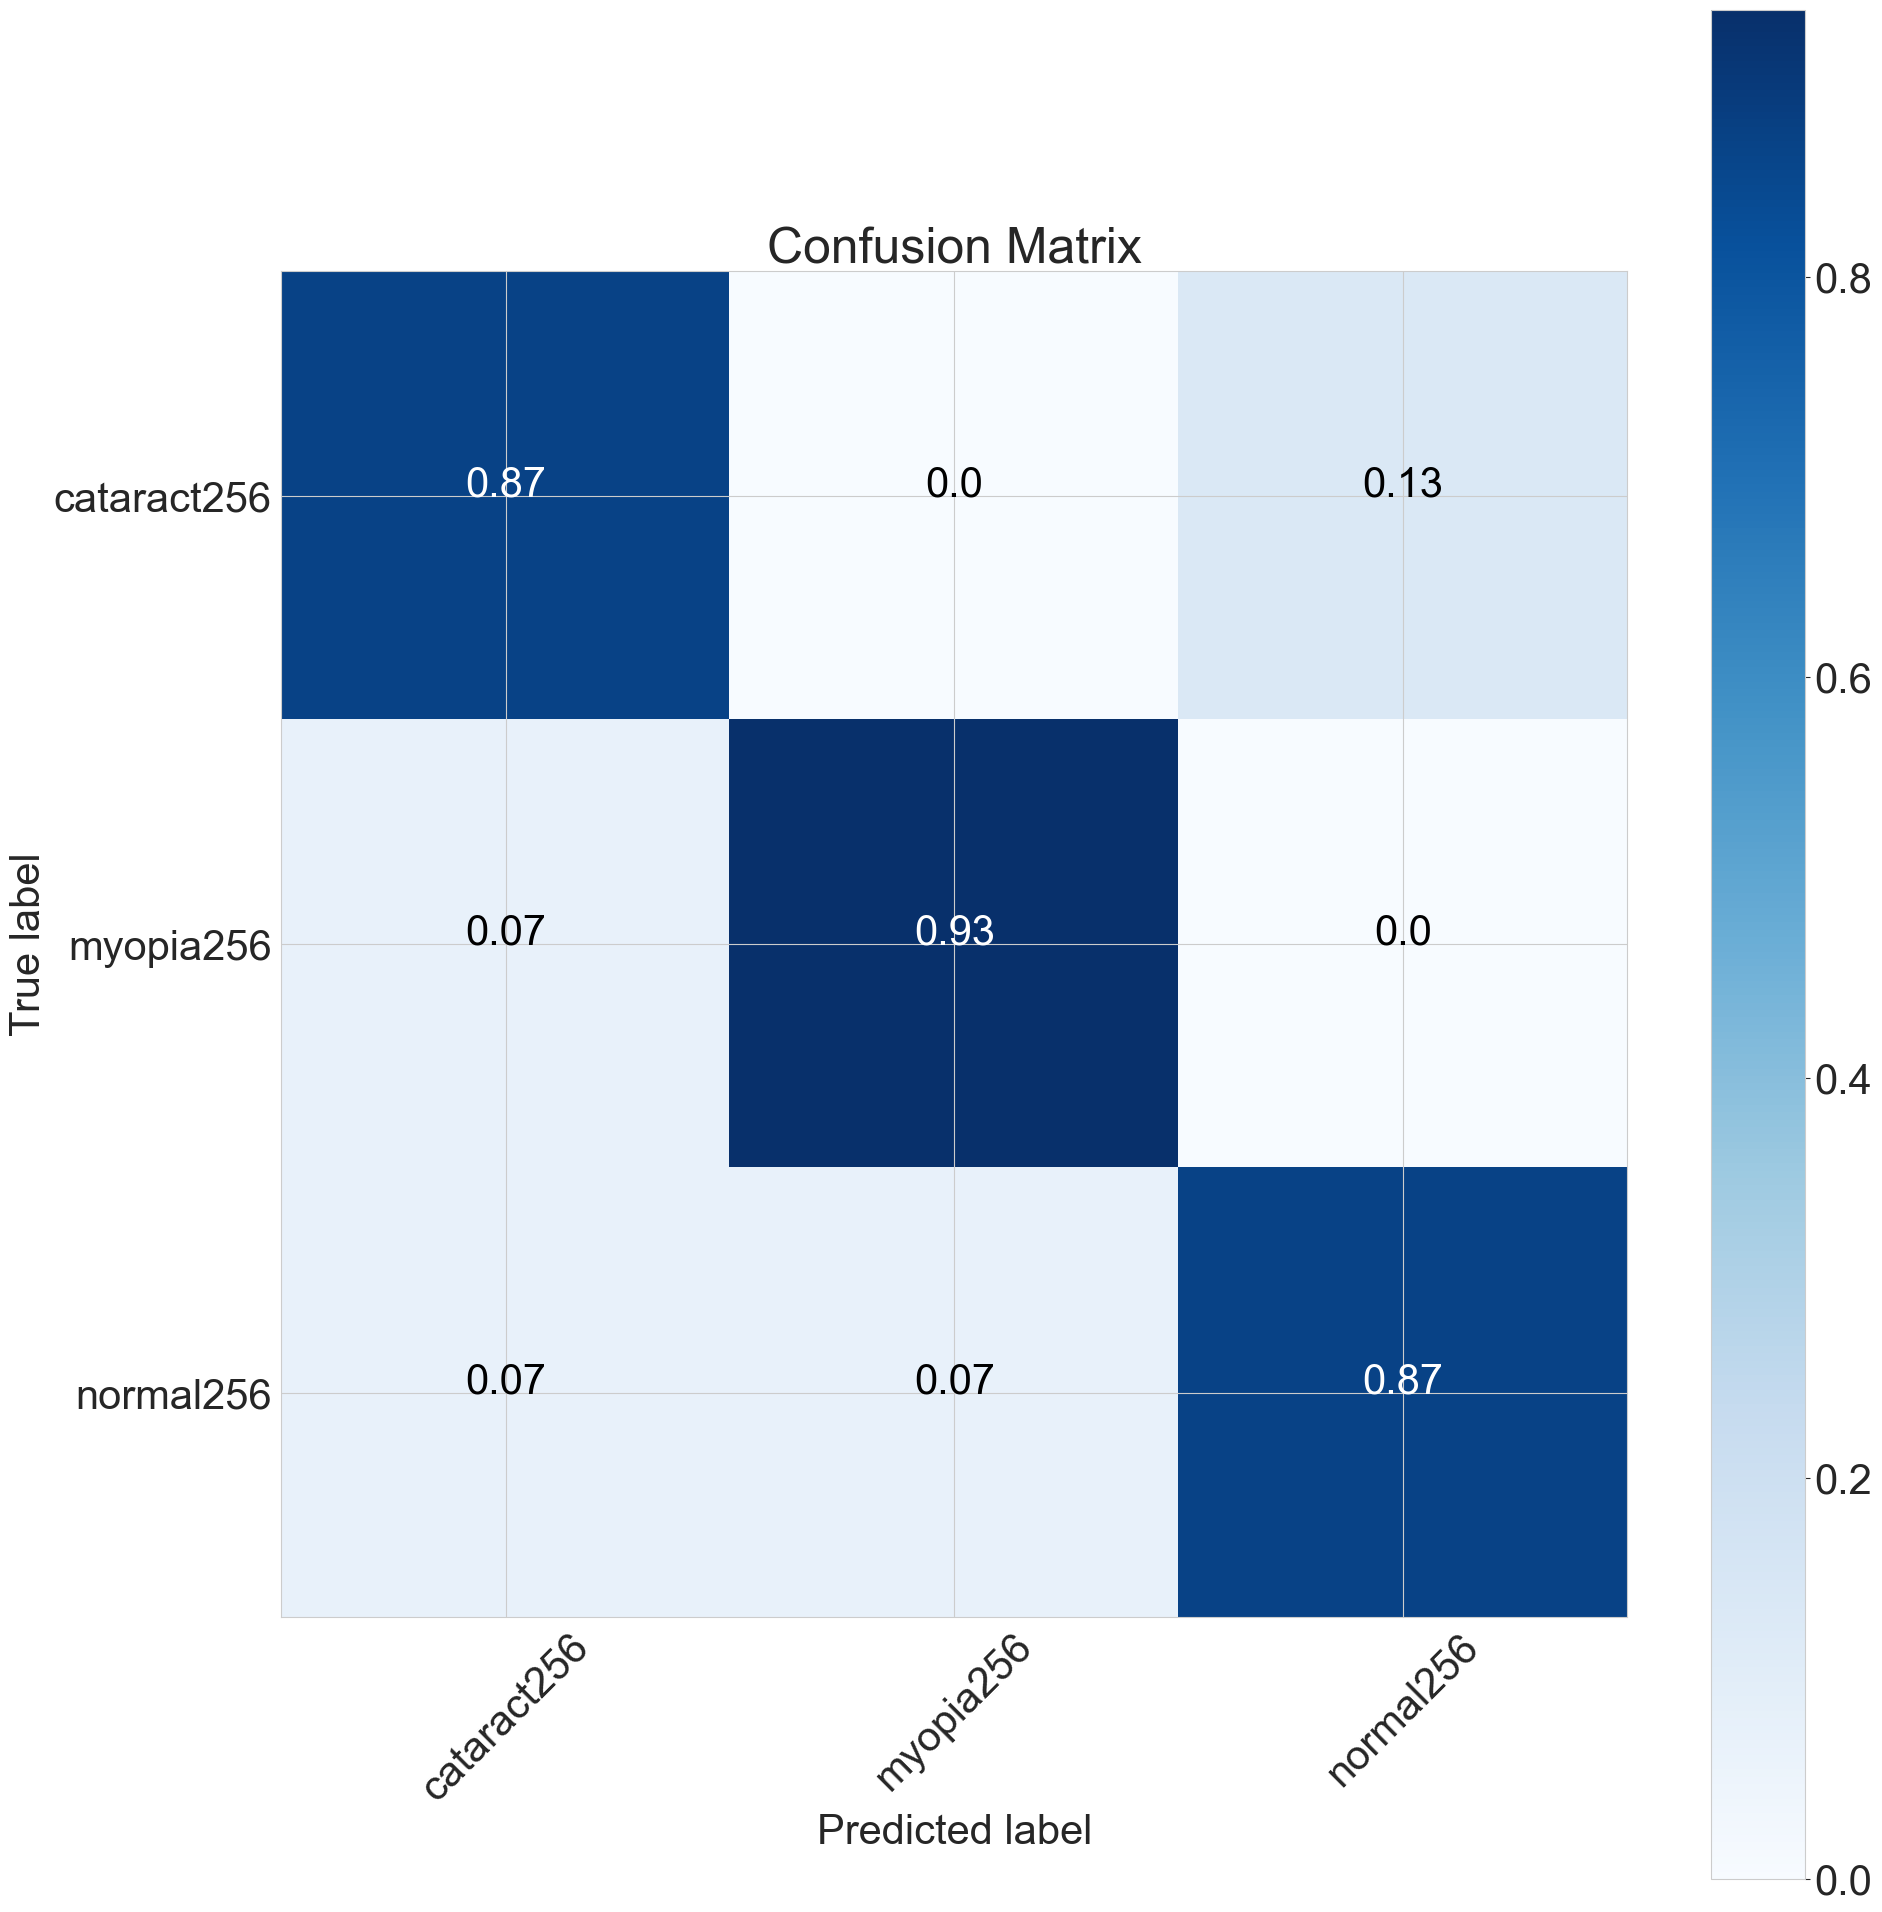

In [32]:
create_conf_mat(train_gen_set1, test_gen_set1, model2)

In the `set01` case imbalance in test set is also terminated.

Test set class distribution in `set0`:
    - 277 `normal`
    - 29 `cataract`
    - 24 `myopia`

Test set class distribution in `set1`:
    - 16 `normal`
    - 16 `cataract`
    - 16 `myopia`


#TODO: 16 isn't a lot, try to increase number of test images

## Create another model

In [33]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    return model

In [34]:
model3 = build_model()
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 256)     

In [35]:
model3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

In [36]:
history3 = model3.fit(
      train_gen_set1,
      steps_per_epoch=100,
      epochs=10,
      validation_data=val_gen_set1,
      validation_steps=5)

Epoch 1/10
100/100 [==============================] - 19s 135ms/step - loss: 0.8559 - precision_2: 0.7419 - recall_2: 0.3793 - accuracy: 0.5827 - val_loss: 0.7805 - val_precision_2: 0.7391 - val_recall_2: 0.6800 - val_accuracy: 0.7067
Epoch 2/10
100/100 [==============================] - 13s 130ms/step - loss: 0.5084 - precision_2: 0.8217 - recall_2: 0.7740 - accuracy: 0.8027 - val_loss: 0.4935 - val_precision_2: 0.8169 - val_recall_2: 0.7733 - val_accuracy: 0.8000
Epoch 3/10
100/100 [==============================] - 13s 130ms/step - loss: 0.4331 - precision_2: 0.8456 - recall_2: 0.8067 - accuracy: 0.8247 - val_loss: 0.3835 - val_precision_2: 0.8657 - val_recall_2: 0.7733 - val_accuracy: 0.8267
Epoch 4/10
100/100 [==============================] - 13s 130ms/step - loss: 0.3727 - precision_2: 0.8758 - recall_2: 0.8507 - accuracy: 0.8620 - val_loss: 0.3810 - val_precision_2: 0.8261 - val_recall_2: 0.7600 - val_accuracy: 0.8267
Epoch 5/10
100/100 [==============================] - 13s 13

In [37]:
test_score = model3.evaluate(test_gen_set1)
print("[INFO] accuracy: {:.2f}%".format(test_score[3] * 100))
print("[INFO] Loss: ", test_score[0])

3/3 [==============================] - 0s 42ms/step - loss: 0.4724 - precision_2: 0.8444 - recall_2: 0.8444 - accuracy: 0.8444
[INFO] accuracy: 84.44%
[INFO] Loss:  0.4723895490169525


In [38]:
test_score

[0.4723895490169525,
 0.8444444537162781,
 0.8444444537162781,
 0.8444444537162781]

3/3 [==============================] - 0s 37ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

 cataract256       0.92      0.73      0.81        15
   myopia256       0.87      0.87      0.87        15
   normal256       0.78      0.93      0.85        15

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45



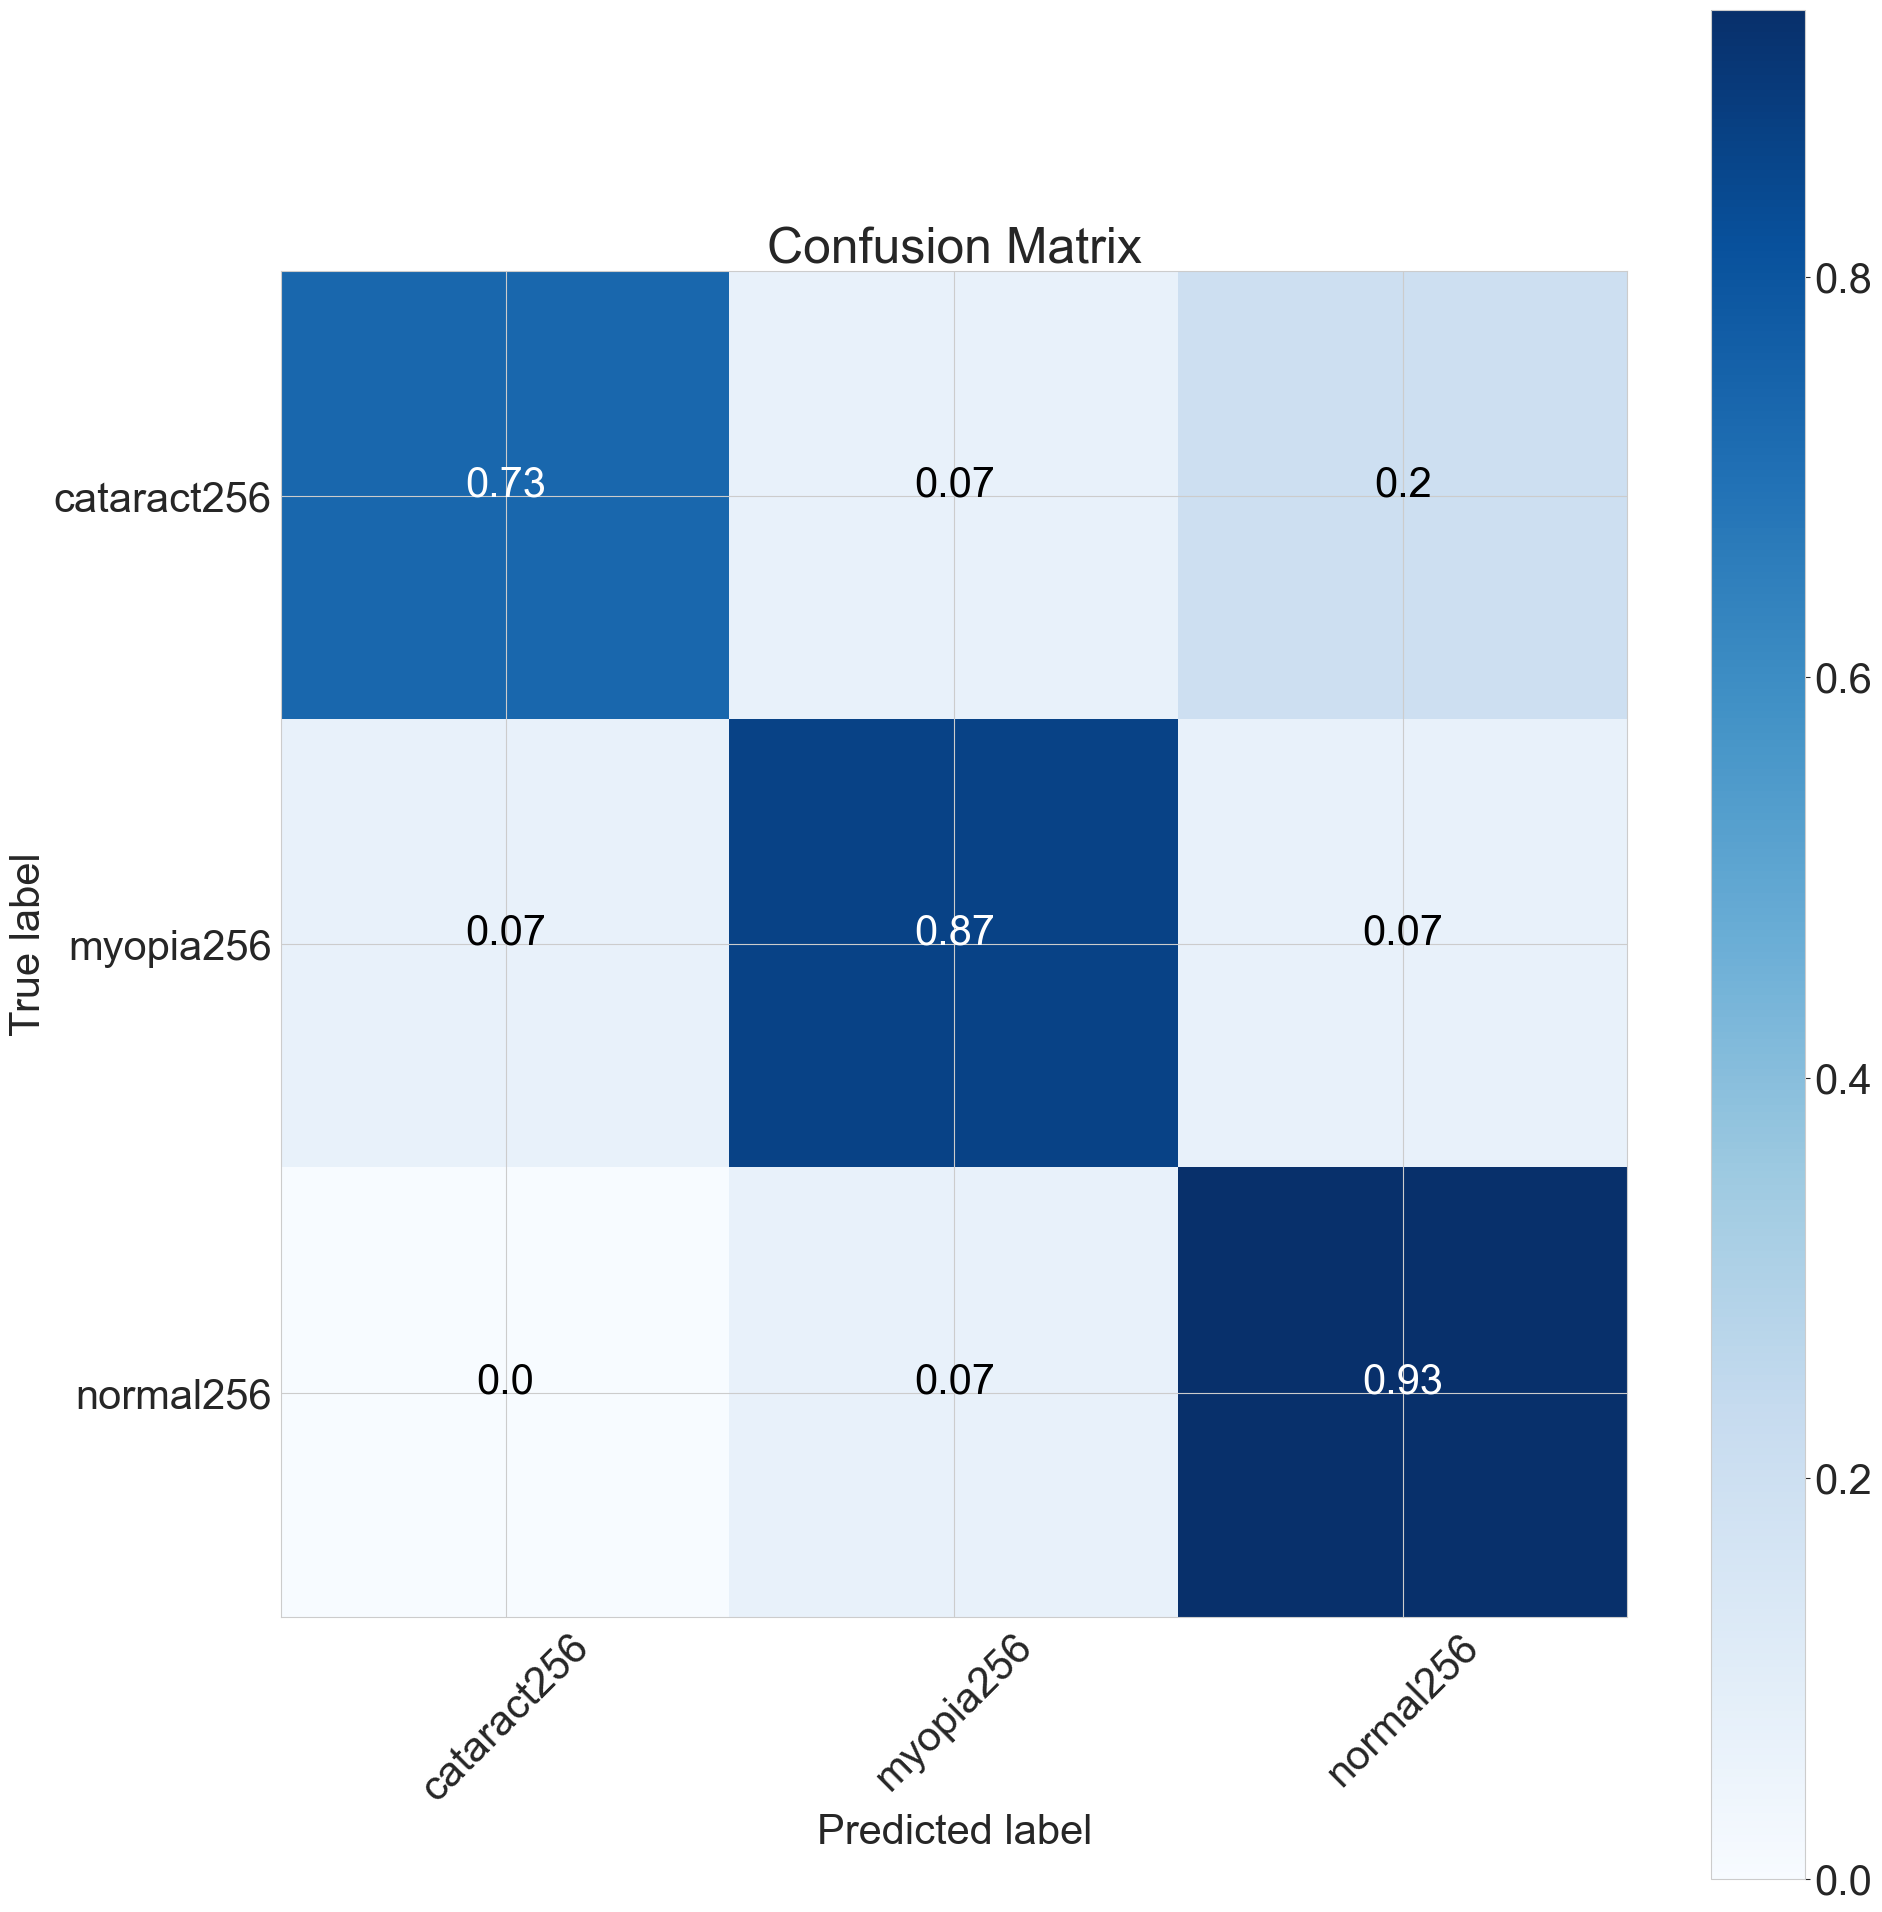

In [42]:
create_conf_mat(train_gen=train_gen_set1, test_gen=test_gen_set1, model=model3)

(the same model was trained on RGB in `07_multiclass.ipynb` with poor results in comparison what we've here)

## Put more images in the test and validation sets

In [23]:
# set 2, oversampling in train  turned on
set2_split_dir = './dataset256_gray/to_split'
set2_output = "./dataset256_gray/set2/output"
# 40 validation img, 40 test images per class
splitfolders.fixed(set2_split_dir, output=set2_output, seed=1337, fixed=(40, 40), oversample=True)

Copying files: 1495 files [00:01, 847.12 files/s]
Oversampling: 3 classes [00:03,  1.21s/ classes]


In [47]:
train_dir_set2 = r'./dataset256_gray/set2/output/train/'
validation_dir_set2 = r'./dataset256_gray/set2/output/val/'
test_dir_set2 = r'./dataset256_gray/set2/output/test/'

print("SET 2 - with oversampling and increased images in test & validation sets")
#  with oversampling
train_gen_set2, val_gen_set2, test_gen_set2 = create_generators(train_dir_set2, test_dir_set2, validation_dir_set2, batch_size=15, class_mode="categorical", img_rows=256, img_cols=256)

SET 2 - with oversampling and increased images in test & validation sets
Found 2760 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


In [48]:
model4 = build_model()
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 256)     

In [49]:
model4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

In [50]:
history4 = model4.fit(
      train_gen_set2,
      steps_per_epoch=100,
      epochs=10,
      validation_data=val_gen_set2,
      validation_steps=5)

Epoch 1/10
100/100 [==============================] - 15s 135ms/step - loss: 0.9310 - precision_4: 0.7053 - recall_4: 0.2680 - accuracy: 0.5347 - val_loss: 0.5280 - val_precision_4: 0.8082 - val_recall_4: 0.7867 - val_accuracy: 0.8000
Epoch 2/10
100/100 [==============================] - 13s 130ms/step - loss: 0.5222 - precision_4: 0.8081 - recall_4: 0.7580 - accuracy: 0.7887 - val_loss: 0.3656 - val_precision_4: 0.9028 - val_recall_4: 0.8667 - val_accuracy: 0.8800
Epoch 3/10
100/100 [==============================] - 13s 131ms/step - loss: 0.4145 - precision_4: 0.8526 - recall_4: 0.8253 - accuracy: 0.8407 - val_loss: 0.6181 - val_precision_4: 0.8429 - val_recall_4: 0.7867 - val_accuracy: 0.8000
Epoch 4/10
100/100 [==============================] - 13s 131ms/step - loss: 0.3951 - precision_4: 0.8574 - recall_4: 0.8380 - accuracy: 0.8493 - val_loss: 0.4301 - val_precision_4: 0.8493 - val_recall_4: 0.8267 - val_accuracy: 0.8400
Epoch 5/10
100/100 [==============================] - 13s 13

In [51]:
test_score = model4.evaluate(test_gen_set2)
print("[INFO] accuracy: {:.2f}%".format(test_score[3] * 100))
print("[INFO] Loss: ", test_score[0])

8/8 [==============================] - 0s 40ms/step - loss: 0.3926 - precision_4: 0.8571 - recall_4: 0.8500 - accuracy: 0.8583
[INFO] accuracy: 85.83%
[INFO] Loss:  0.3926318883895874


8/8 [==============================] - 1s 79ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

 cataract256       0.88      0.90      0.89        40
   myopia256       0.90      0.88      0.89        40
   normal256       0.80      0.80      0.80        40

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



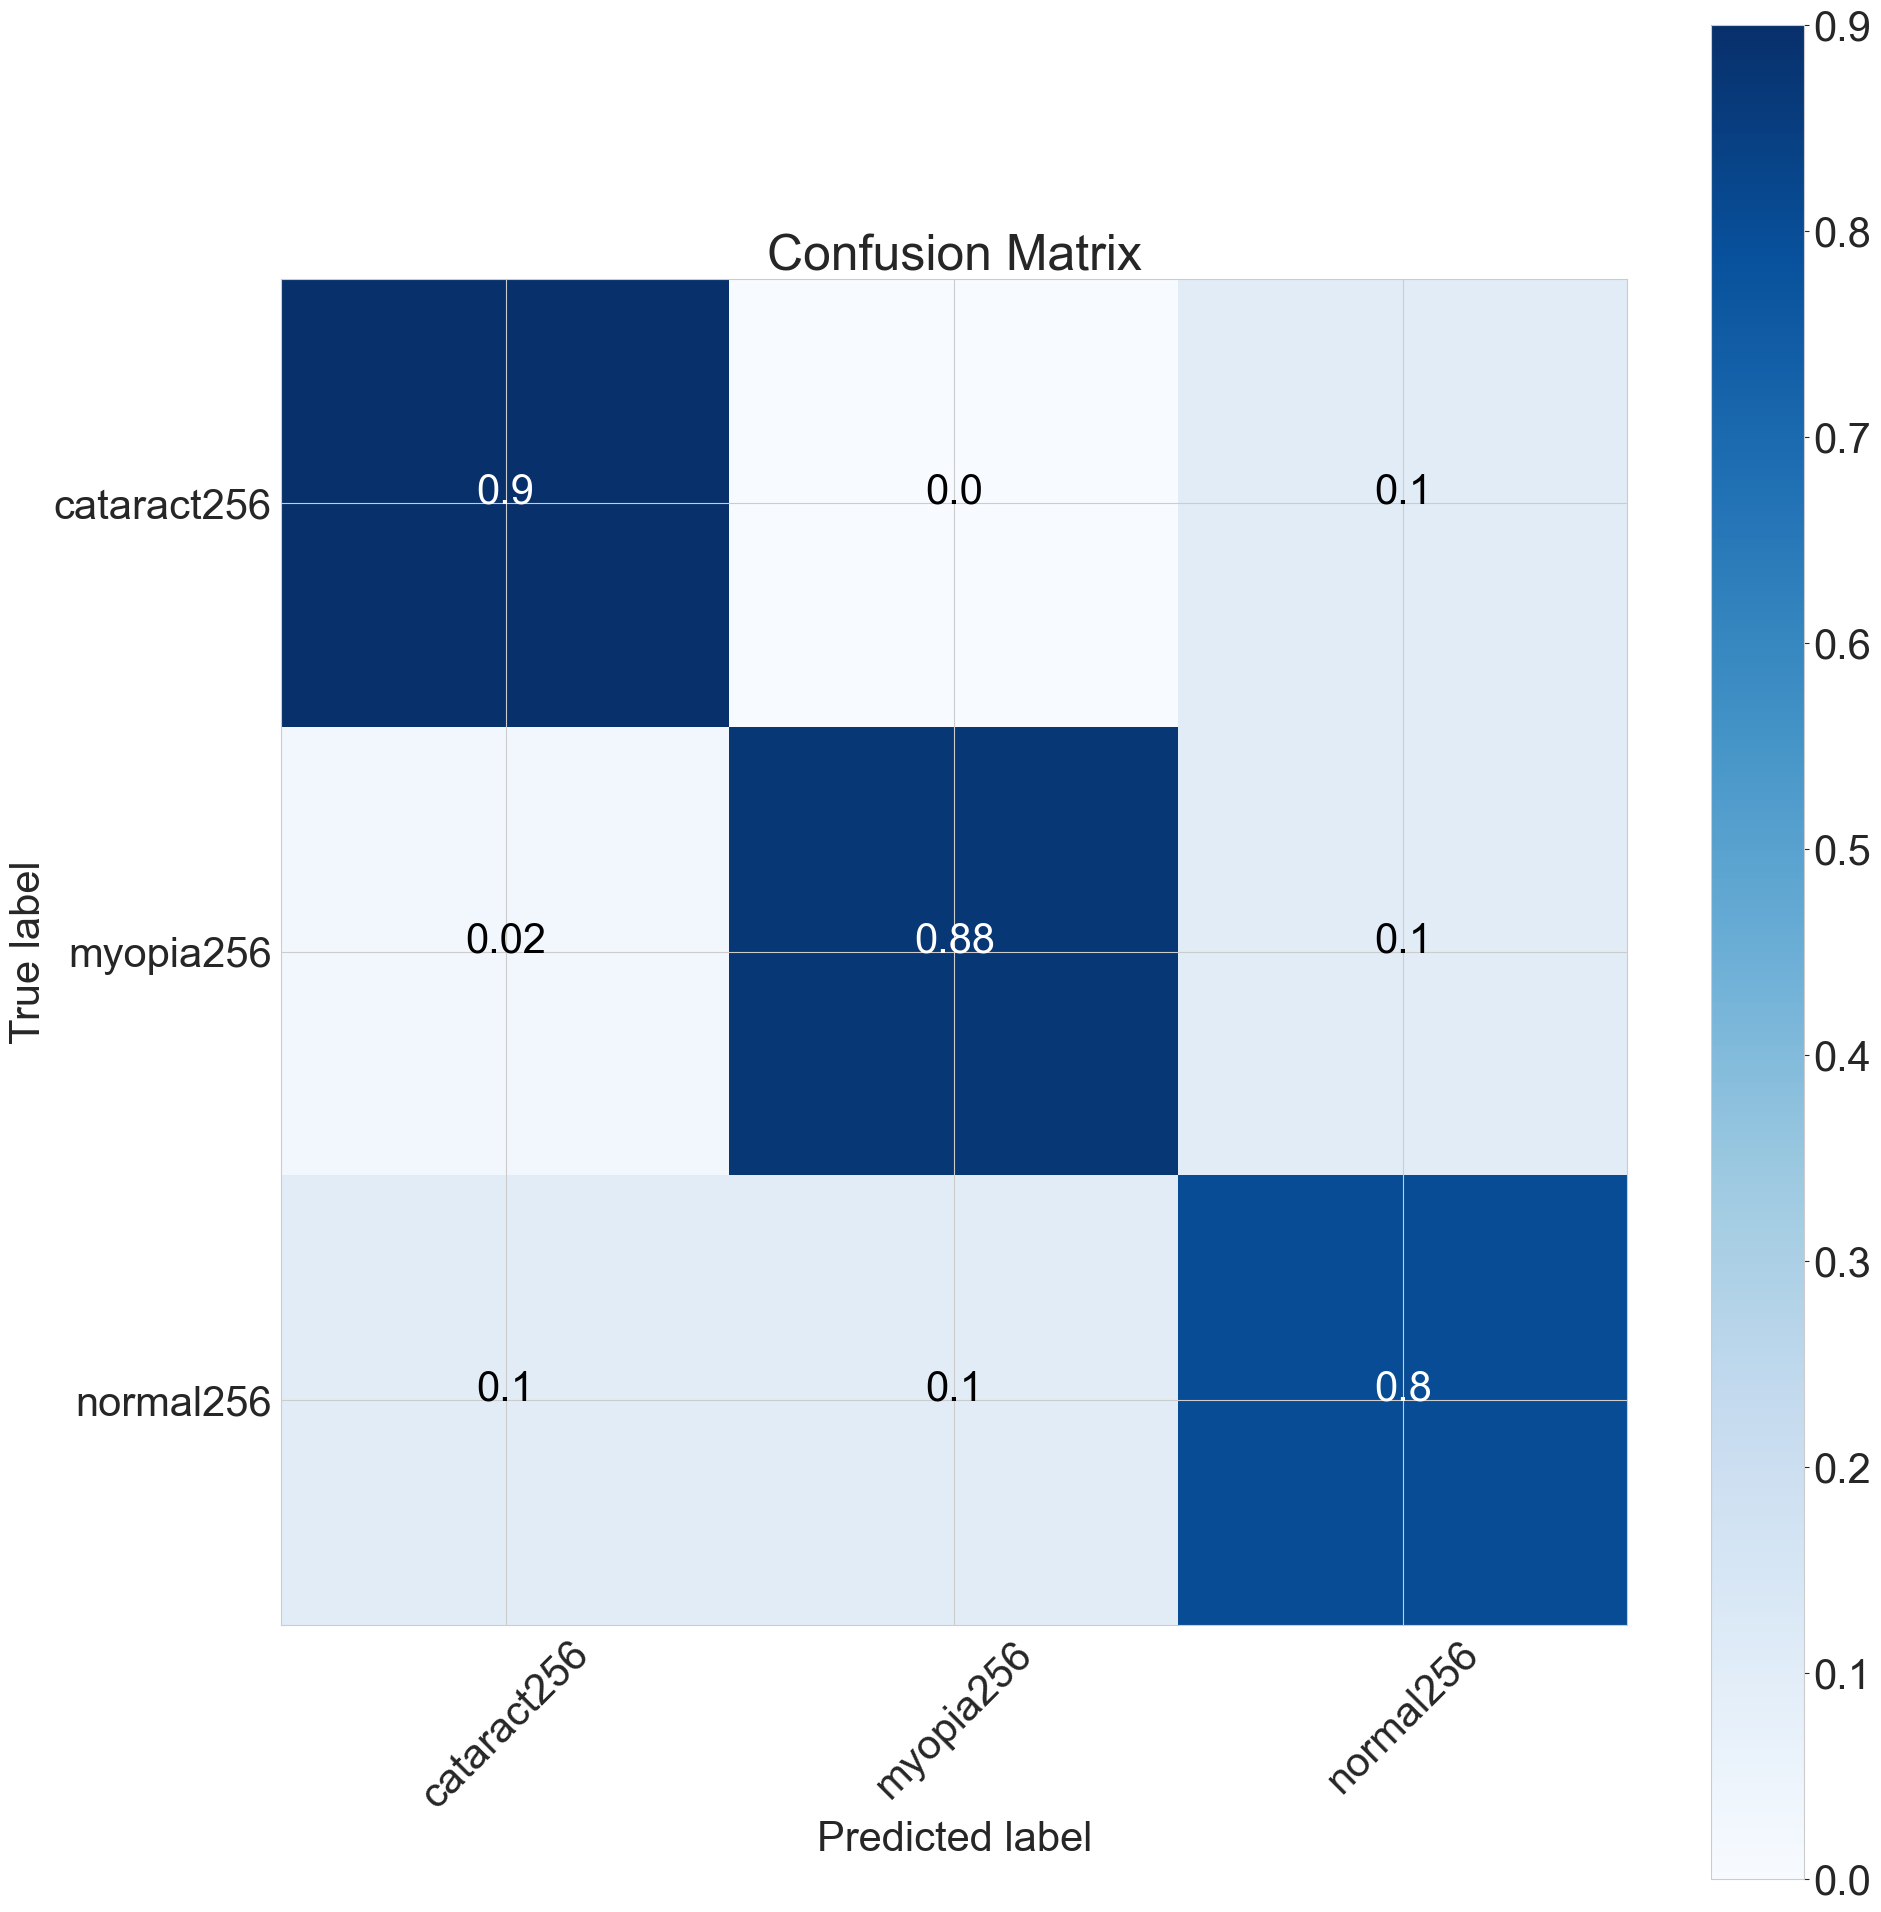

In [52]:
create_conf_mat(train_gen=train_gen_set2, test_gen=test_gen_set2, model=model4)

In [43]:
history4.history.keys()

dict_keys(['loss', 'precision_1', 'recall_1', 'accuracy', 'val_loss', 'val_precision_1', 'val_recall_1', 'val_accuracy'])

In [45]:
# test set has balanced distribution so accuracy makes sense this time
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

precision4 = np.array(history4.history['precision_1'])
val_precision4 = np.array(history4.history['val_precision_1'])
recall4 = np.array(history4.history['recall_1'])
val_recall4 = np.array(history4.history['val_recall_1'])

In [46]:
def F1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)


def plot_metrics(precision, val_precision, recall, val_recall):
    # F1-Score
    f1 = F1(precision, recall)
    f1_val = F1(val_precision, val_recall)

    fig, axs = plt.subplots(3, figsize=(9, 9))

    axs[0].plot(precision, 'b.')
    axs[0].plot(val_precision)
    axs[0].set_title('Precision vs Validation Precision')
    axs[1].plot(recall, 'b.')
    axs[1].plot(val_recall)
    axs[1].set_title('Recall vs Validation Recall')
    axs[2].plot(f1, 'b.')
    axs[2].plot(f1_val)
    axs[2].set_title('F1 vs Validation F1')
    plt.show()

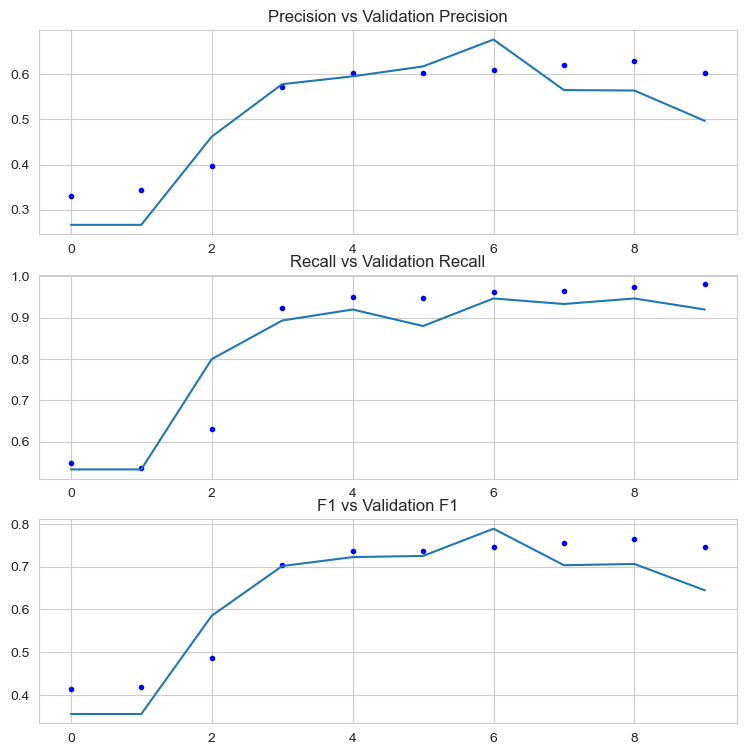

In [47]:
plot_metrics(precision4, val_precision4, recall4, val_recall4)

In [50]:
def plot_metric(train_metric, val_metric, metric_name):
    plt.plot(train_metric, 'b.', label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.legend()
    plt.title('Loss vs Validation Loss')

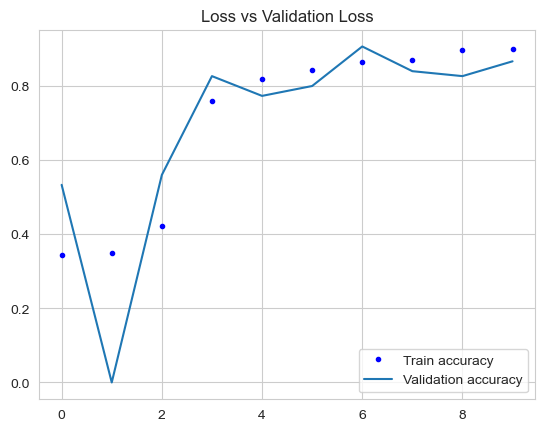

In [52]:
plot_metric(acc4, val_acc4, 'accuracy')

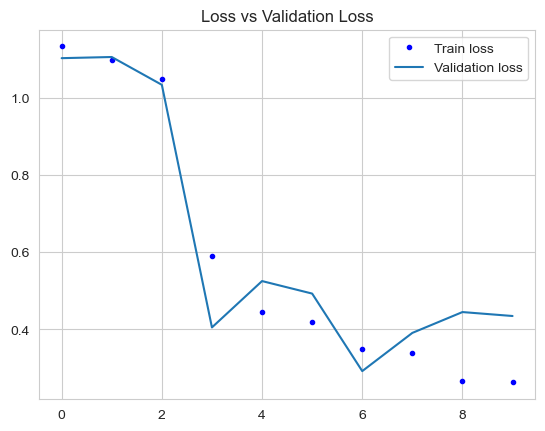

In [53]:
plot_metric(loss4, val_loss4, 'loss')

## Comparison with RGB dataset instead of grayscale

In [ ]:
# set 2, oversampling in train  turned on
set2_split_dir_RGB = './dataset256_gray/to_split_color'
set2_output_RGB = "./dataset256_gray/set2/output_color"
# 40 validation img, 40 test images per class
splitfolders.fixed(set2_split_dir_RGB, output=set2_output_RGB, seed=1337, fixed=(40, 40), oversample=True)

In [55]:
def create_generators(train_dir, test_dir, validation_dir, batch_size=15, class_mode="categorical", img_rows=256, img_cols=256, color_mode='grayscale'):
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=30,
        # shear_range=0.2,
        # zoom_range=0.05
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.1,
        # brightness_range=(0.9, 1.1)
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        # The size of batches of images
        batch_size=batch_size,
        shuffle=True,
        class_mode=class_mode,
        color_mode=color_mode)

    test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        # The size of batches of images
        batch_size=batch_size,
        class_mode=class_mode,
        color_mode=color_mode,
        # WARNING! SHUFFLE must be set to `False`, without it confusion matrix gets wrong labels
        # and it can lead to hours spent on debugging
        shuffle=False)

    validation_generator = validation_datagen.flow_from_directory(
        # This is the target directory
        validation_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        # The size of batches of images
        batch_size=batch_size,
        class_mode=class_mode,
        color_mode=color_mode,
        # WARNING! SHUFFLE must be set to `False`, without it confusion matrix gets wrong labels
        # and it can lead to hours spent on debugging
        shuffle=False)

    return train_generator, validation_generator, test_generator

In [56]:
train_dir_set2_RGB = r'./dataset256_gray/set2/output_color/train/'
validation_dir_set2_RGB = r'./dataset256_gray/set2/output_color/val/'
test_dir_set2_RGB = r'./dataset256_gray/set2/output_color/test/'

print("SET 2 - with oversampling and increased images in test & validation sets + this time in color")
train_gen_set2_RGB, val_gen_set2_RGB, test_gen_set2_RGB = create_generators(train_dir_set2_RGB, test_dir_set2_RGB, validation_dir_set2_RGB, batch_size=15, class_mode="categorical", img_rows=256, img_cols=256, color_mode='rgb')

SET 2 - with oversampling and increased images in test & validation sets + this time in color
Found 2760 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


### Test the same model on the same images but this time in color

In [57]:
model5 = models.Sequential()
model5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(256, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(512, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(256, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Flatten())
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(3, activation='softmax'))

model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 30, 30, 256)     

In [58]:
model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

In [59]:
history5 = model5.fit(
      train_gen_set2_RGB,
      steps_per_epoch=100,
      epochs=10,
      validation_data=val_gen_set2_RGB,
      validation_steps=5)

Epoch 1/10
100/100 [==============================] - 26s 228ms/step - loss: 1.0397 - precision_5: 0.5940 - recall_5: 0.1327 - accuracy: 0.4473 - val_loss: 0.7811 - val_precision_5: 0.9250 - val_recall_5: 0.4933 - val_accuracy: 0.8267
Epoch 2/10
100/100 [==============================] - 22s 217ms/step - loss: 0.7966 - precision_5: 0.7279 - recall_5: 0.4833 - accuracy: 0.6473 - val_loss: 0.5636 - val_precision_5: 0.8857 - val_recall_5: 0.8267 - val_accuracy: 0.8400
Epoch 3/10
100/100 [==============================] - 20s 203ms/step - loss: 0.6702 - precision_5: 0.7572 - recall_5: 0.6467 - accuracy: 0.7200 - val_loss: 0.5372 - val_precision_5: 0.8824 - val_recall_5: 0.8000 - val_accuracy: 0.8267
Epoch 4/10
100/100 [==============================] - 21s 206ms/step - loss: 0.5489 - precision_5: 0.7925 - recall_5: 0.7360 - accuracy: 0.7740 - val_loss: 0.5089 - val_precision_5: 0.8611 - val_recall_5: 0.8267 - val_accuracy: 0.8533
Epoch 5/10
100/100 [==============================] - 22s 21

In [60]:
test_score = model5.evaluate(test_gen_set2_RGB)
print("[INFO] accuracy: {:.2f}%".format(test_score[3] * 100))
print("[INFO] Loss: ", test_score[0])

8/8 [==============================] - 0s 44ms/step - loss: 0.3285 - precision_5: 0.9027 - recall_5: 0.8500 - accuracy: 0.8667
[INFO] accuracy: 86.67%
[INFO] Loss:  0.3285072147846222


8/8 [==============================] - 0s 39ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

 cataract256       0.81      0.97      0.89        40
   myopia256       0.97      0.85      0.91        40
   normal256       0.84      0.78      0.81        40

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.87      0.87       120



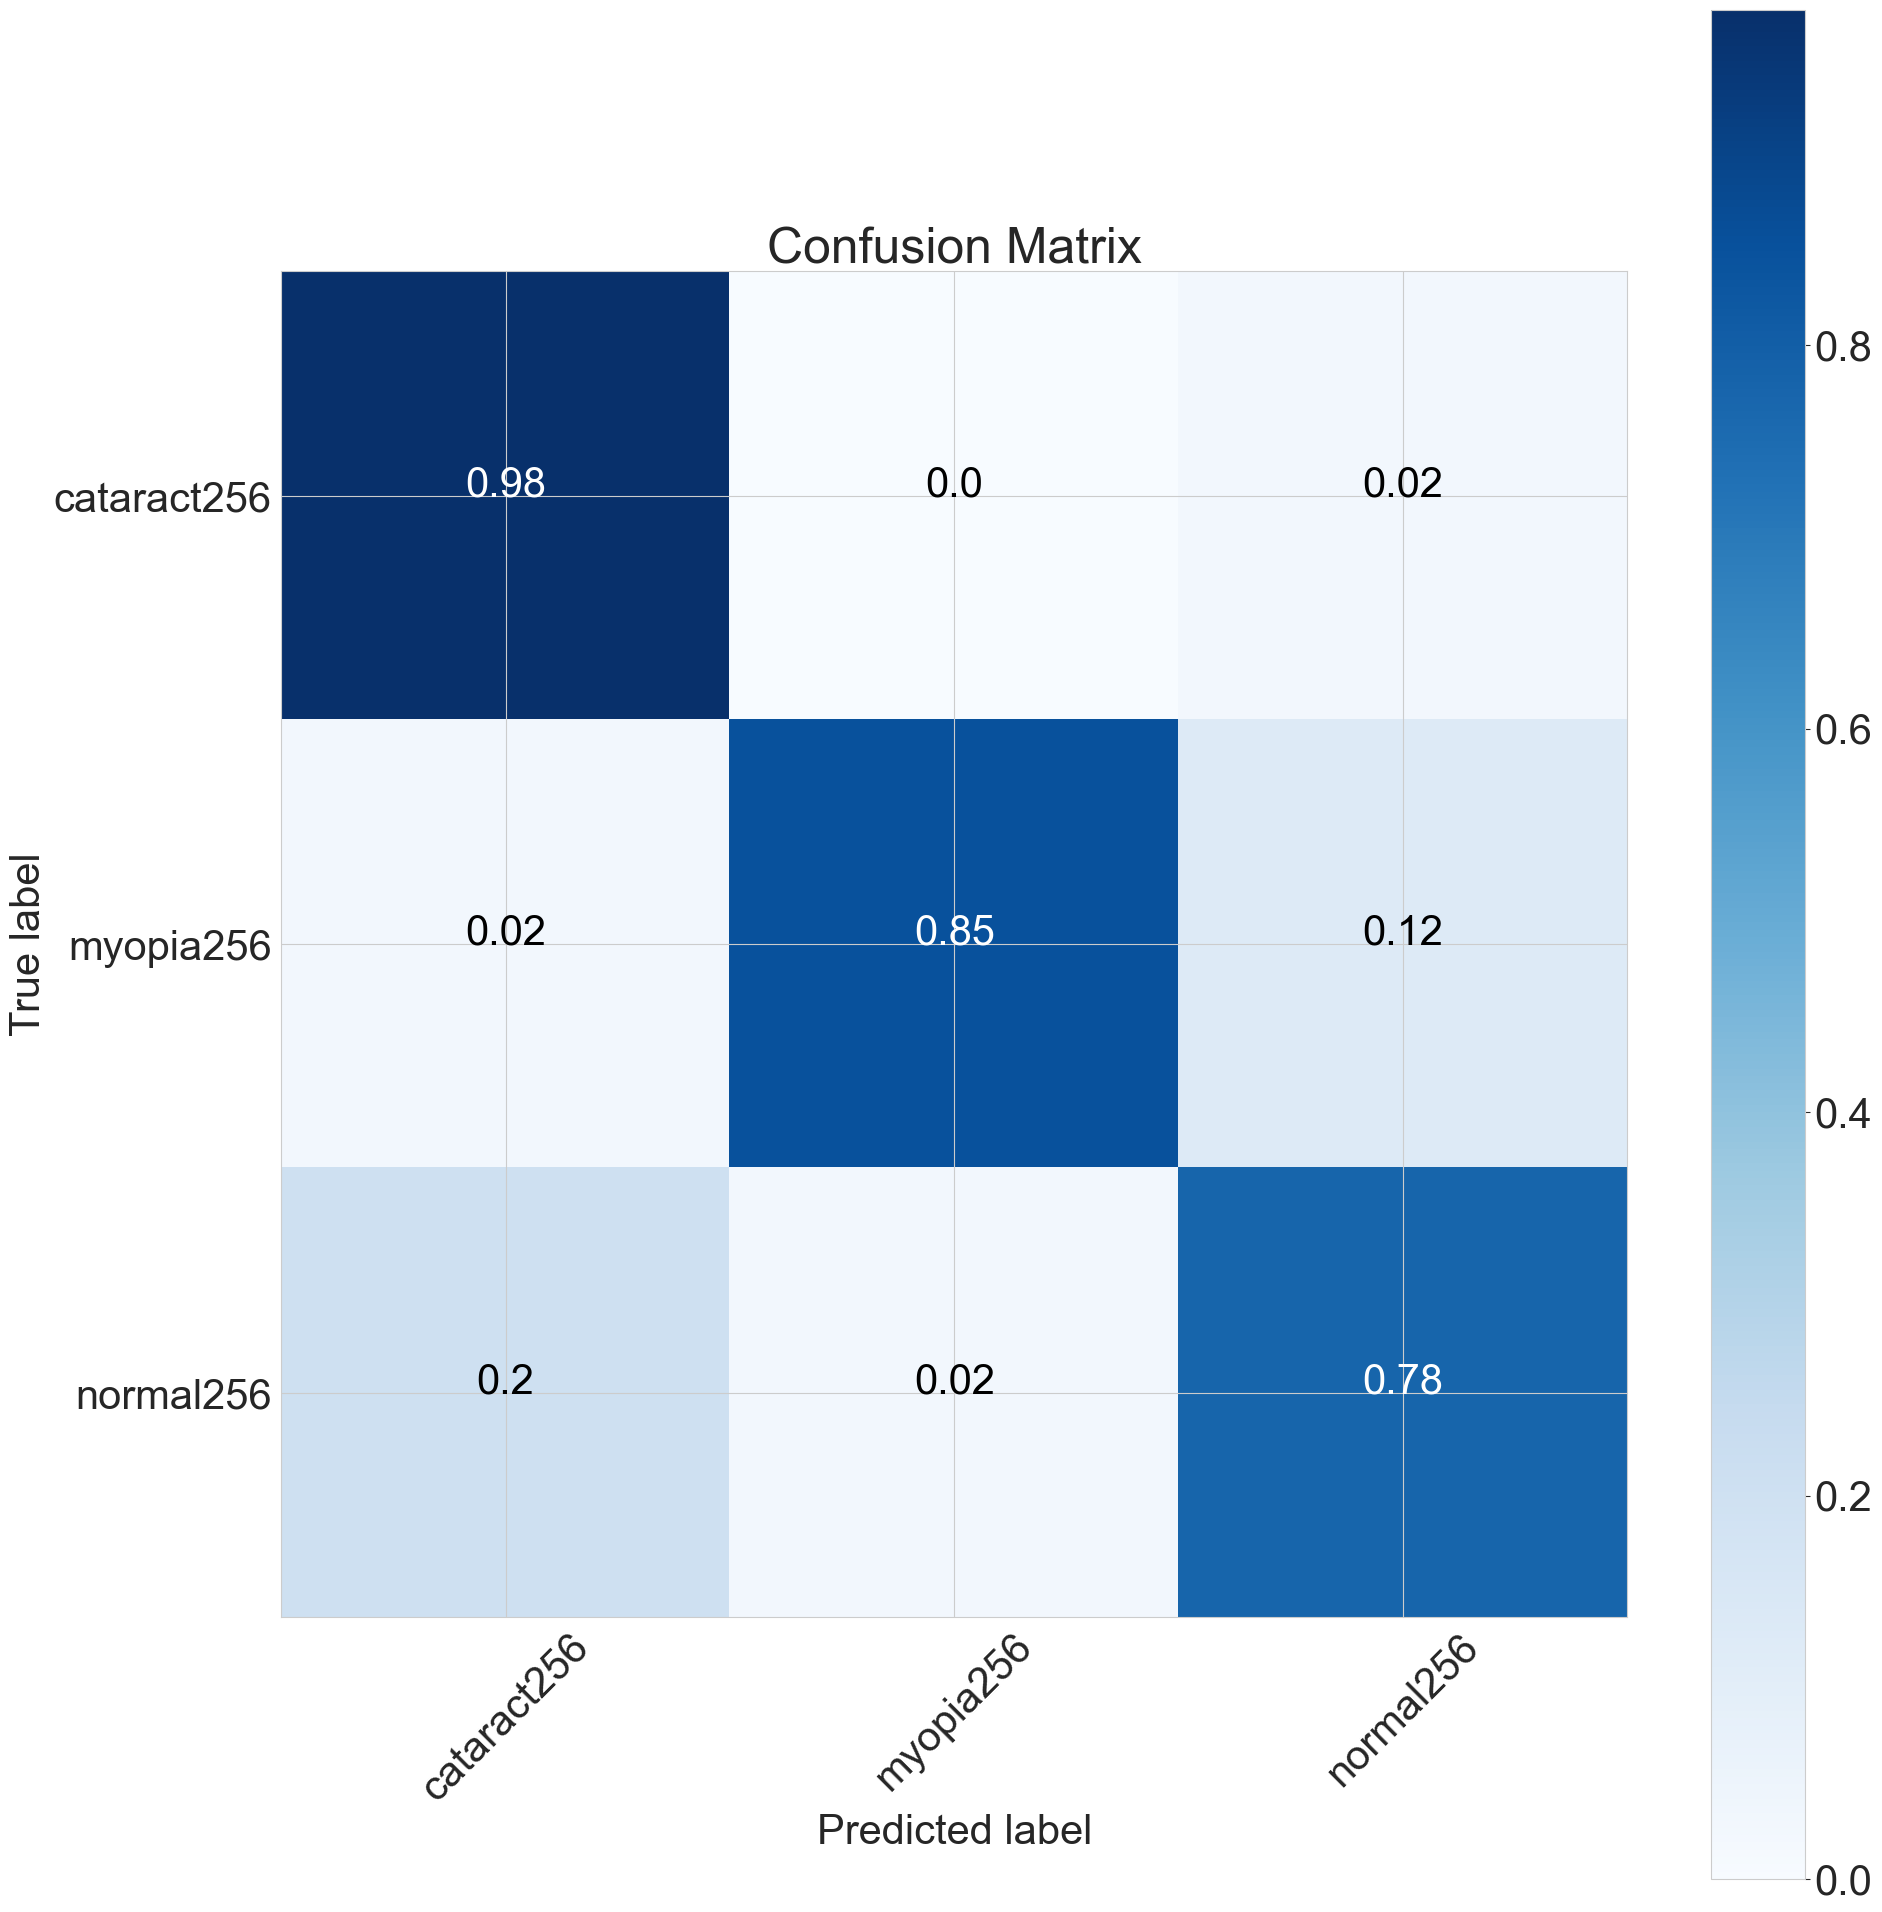

In [61]:
create_conf_mat(train_gen=train_gen_set2_RGB, test_gen=test_gen_set2_RGB, model=model5)

In [108]:
history5.history.keys()

dict_keys(['loss', 'precision_9', 'recall_9', 'accuracy', 'val_loss', 'val_precision_9', 'val_recall_9', 'val_accuracy'])

In [109]:
# test set has balanced distribution so accuracy makes sense this time
acc5 = history5.history['accuracy']
val_acc5 = history5.history['val_accuracy']
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']

precision5 = np.array(history5.history['precision_9'])
val_precision5 = np.array(history5.history['val_precision_9'])
recall5 = np.array(history5.history['recall_9'])
val_recall5 = np.array(history5.history['val_recall_9'])

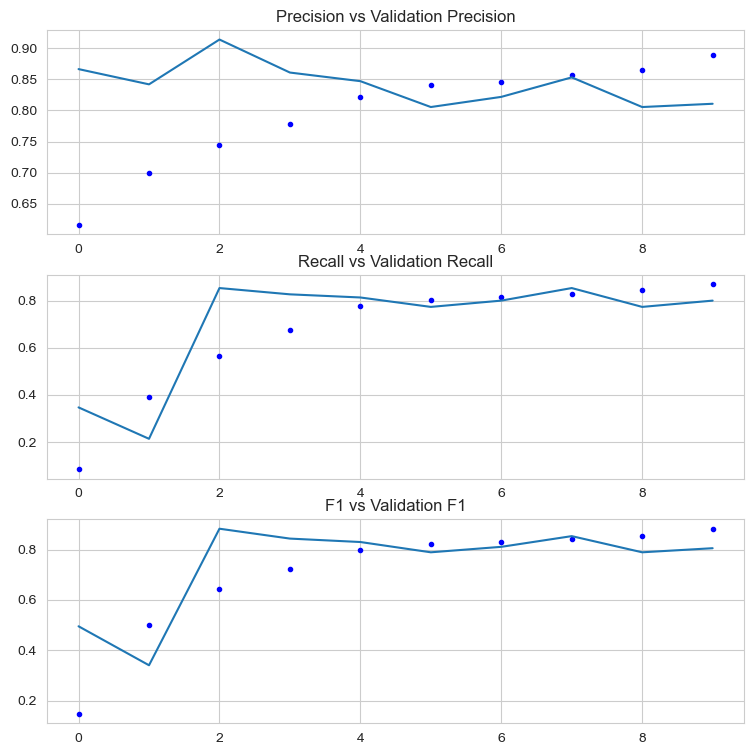

In [111]:
plot_metrics(precision5, val_precision5, recall5, val_recall5)

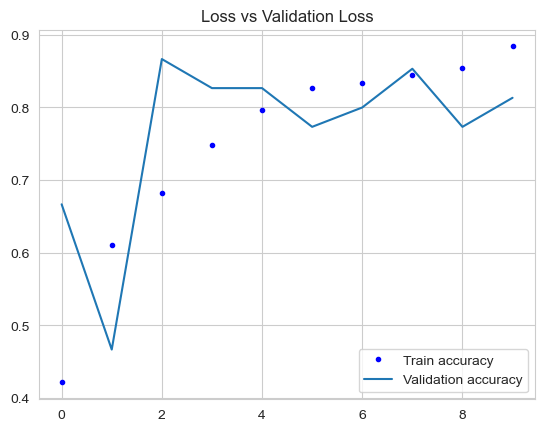

In [112]:
plot_metric(acc5, val_acc5, 'accuracy')

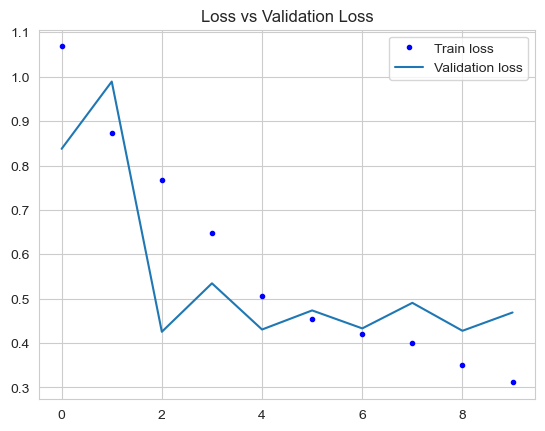

In [113]:
plot_metric(loss5, val_loss5, 'loss')

In [115]:
model5.save(models_dir + '/model5_RGB_n10.h5')

#### Finally my model started classifying images properly after some image processing and cut on number of classes.